# Import modules

If not installed, install plotly for visualising 3d graphics.

In [1]:
# !pip install plotly

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import plotly.express as px

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

Set unified parameters for use throughout the notebook.

In [3]:
RANDOM_STATE = 11919925
warnings.filterwarnings("ignore")
plt.style.use("fast")
plt.rcParams["figure.dpi"] = 170

# Import dataset and data cleaning

In [4]:
file_name = "TeleCom_Data.csv"
data = pd.read_csv(file_name, delimiter='"";""|;|";"|;"', engine='python')

In [5]:
data.head()

"age          ""job  marital            education  default housing loan  \
0  "40       ""admin.  married             basic.6y       no      no   no   
1  "56     ""services  married          high.school       no      no  yes   
2  "45     ""services  married             basic.9y  unknown      no   no   
3  "59       ""admin.  married  professional.course       no      no   no   
4  "41  ""blue-collar  married              unknown  unknown      no   no   

     contact month day_of_week  ...  campaign  pdays  previous  \
0  telephone   may       mon""  ...         1    999         0   
1  telephone   may       mon""  ...         1    999         0   
2  telephone   may       mon""  ...         1    999         0   
3  telephone   may       mon""  ...         1    999         0   
4  telephone   may       mon""  ...         1    999         0   

          poutcome emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
0  ""nonexistent""          1.1          93.994          -36.4      4.857   
1  ""nonexistent""          1.1          93.994          -36.4      4.857   
2  ""nonexistent""          1.1          93.994          -36.4      4.857   
3  ""nonexistent""          1.1          93.994          -36.4      4.857   
4  ""nonexistent""          1.1          93.994          -36.4      4.857   

   nr.employed     y"""  
0       5191.0  ""no"""  
1       5191.0  ""no"""  
2       5191.0  ""no"""  
3       5191.0  ""no"""  
4       5191.0  ""no"""  

[5 rows x 21 columns]

In [6]:
data.shape

(41180, 21)

The following cells employ the exact same data cleaning steps as done in assignment 1. This is to get the final dataset for modelling.

In [7]:
# Rename columns
name_dict = {
    '"age': 'age',
    '""job': 'job',
    'y"""': 'y'
}

data.rename(name_dict, axis='columns', inplace=True)

In [8]:
# Age data
data['age'].replace('"', '', regex=True, inplace=True)
data['age'] = data['age'].astype(int)

In [9]:
# Job data
data['job'].replace('""', '', regex=True, inplace=True)

In [10]:
# Day of week data
data['day_of_week'].replace('""', '', regex=True, inplace=True)

In [11]:
# poutcome data
data['poutcome'].replace('""', '', regex=True, inplace=True)

In [12]:
# The target variable
data['y'].replace('[""]|["""]', '', regex=True, inplace=True)

In [13]:
# Setting all missing instances of pdays where 'previous = 0' to -1
data.loc[
    (data['pdays'] == 999) &
    (data['previous'] == 0),
    'pdays'
] = -1

In [14]:
def generate_empirical_conditional_pmf(data: pd.DataFrame, previous: int) -> (np.ndarray, np.ndarray):
    """
    Generates the empirical conditional probability mass function (pmf) of `pdays` values, given
    a value of `previous`.
    
    ------------
    Input(s):
    data : input data
    previous : number of contacts performed before this campaign and for this client 
    
    ------------
    Output(s):
    pdays : the conditional sample space for `pdays`
    conditional_probability : the corresponding conditional probabilities for `pdays`
    
    """
    # Assert validity conditions
    assert previous != 0, 'Previous cannot be zero; this outcome is deterministic.'
    assert previous in range(1, 8), 'Previous cannot be outside pmf range.'
    
    # Define data masks to filter the dataset on
    mask_not_999 = data['pdays'] != 999
    mask_previous = data['previous'] == previous
    
    # Filter the dataset according to masks, then choose `pdays` column
    conditional_pdays = data[mask_not_999 & mask_previous]['pdays']
    
    # Get probabilities by retrieving normalised value counts
    probability_of_values = conditional_pdays.value_counts(normalize=True)
    
    # Retrieve the results and return them
    pdays = probability_of_values.index
    conditional_probability = probability_of_values.values
    
    return pdays, conditional_probability


def get_size_999(
        data: pd.DataFrame,
        previous: int
) -> int:
    """
    Gets the size of the missing instances vector, depending on the value of `previous`.
    
    ------------
    Input(s):
    data : input data
    previous : number of contacts performed before this campaign and for this client 
    
    ------------
    Output(s):
    vector_size : the size of the missing instances vector.
    
    """
    # Filter missing data
    mask_999 = data['pdays'] == 999
    mask_previous = data['previous'] == previous
    
    # Get the missing data vector size
    vector_size = len(data[mask_999 & mask_previous])
    
    return vector_size    


def generate_random_pdays_vector(
        val: np.ndarray,
        prob: np.ndarray,
        data: pd.DataFrame,
        previous: int,
        seed: int=1
) -> np.ndarray:
    """
    Generates the random pdays vector according to the empirical conditional pmf.
    
    ------------
    Input(s):
    val : the conditional sample space for `pdays`
    prob : the corresponding conditional probabilities for `pdays`
    data : input data
    previous : number of contacts performed before this campaign and for this client
    seed (default=1) : the random seed for the Numpy random generator, for reproducibility
    
    ------------
    Output(s):
    random_pdays_vector : the generated random vector.    
    
    """
    # Set the random seed for reproducibility
    np.random.seed(seed)
    
    # Generate the random pdays vector
    random_pdays_vector = np.random.choice(
        a=val,
        size=get_size_999(data, previous),
        replace=True,
        p=prob
    )
    
    return random_pdays_vector


In [15]:
# Generate and fill the data into the dataframe
for i in range(1, 8):
    cond_pdays, cond_prob = generate_empirical_conditional_pmf(data, i)
    rand_pdays_vec = generate_random_pdays_vector(cond_pdays, cond_prob, data, i)
    
    data.loc[
        (data['pdays'] == 999) &
        (data['previous'] == i),
        'pdays'
    ] = rand_pdays_vec

Before modelling, I ensure that I don't include the rows where `duration = 0`, because it is perfectly correlated with the target variable, and does not give meaningful results in predictive modelling. We only want to predict customers who have at least chatted to us.

In [16]:
# Check how many rows has `duration` == 0
data[data['duration']==0]['y']

6247     no
23027    no
28059    no
33011    no
Name: y, dtype: object

We are only dropping 4 records, which is minimal.

In [17]:
# Drop rows
data = data.drop(data[data['duration']==0].index).reset_index(drop=True)

# Separate and binarise the response variable

In [18]:
y = data.pop('y')
y = y.map({'no': 0, 'yes': 1})

# Response variable ratio

In [19]:
y.value_counts(normalize=True)

y
0    0.887362
1    0.112638
Name: proportion, dtype: float64

The proportion of yeses is significantly lower. This calls for a stratified train-test split during model training.

# Data preprocessing

In [20]:
data.head()

age          job  marital            education  default housing loan  \
0   40       admin.  married             basic.6y       no      no   no   
1   56     services  married          high.school       no      no  yes   
2   45     services  married             basic.9y  unknown      no   no   
3   59       admin.  married  professional.course       no      no   no   
4   41  blue-collar  married              unknown  unknown      no   no   

     contact month day_of_week  duration  campaign  pdays  previous  \
0  telephone   may         mon       151         1     -1         0   
1  telephone   may         mon       307         1     -1         0   
2  telephone   may         mon       198         1     -1         0   
3  telephone   may         mon       139         1     -1         0   
4  telephone   may         mon       217         1     -1         0   

      poutcome  emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
0  nonexistent           1.1          93.994          -36.4      4.857   
1  nonexistent           1.1          93.994          -36.4      4.857   
2  nonexistent           1.1          93.994          -36.4      4.857   
3  nonexistent           1.1          93.994          -36.4      4.857   
4  nonexistent           1.1          93.994          -36.4      4.857   

   nr.employed  
0       5191.0  
1       5191.0  
2       5191.0  
3       5191.0  
4       5191.0

There are some `unknown` values, which I haven't treated in assignment 1. I will investigate the unique values in each column to see if I can classify them as missing values.

## NA imputation

In [21]:
for col in data.select_dtypes(include="object").columns:
    print(f"Column '{col}' unique values:\n{data[col].unique()}\n")

Column 'job' unique values:
['admin.' 'services' 'blue-collar' 'technician' 'housemaid' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']

Column 'marital' unique values:
['married' 'single' 'divorced' 'unknown']

Column 'education' unique values:
['basic.6y' 'high.school' 'basic.9y' 'professional.course' 'unknown'
 'basic.4y' 'university.degree' 'illiterate']

Column 'default' unique values:
['no' 'unknown' 'yes']

Column 'housing' unique values:
['no' 'yes' 'unknown']

Column 'loan' unique values:
['no' 'yes' 'unknown']

Column 'contact' unique values:
['telephone' 'cellular']

Column 'month' unique values:
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']

Column 'day_of_week' unique values:
['mon' 'tue' 'wed' 'thu' 'fri']

Column 'poutcome' unique values:
['nonexistent' 'failure' 'success']



It is reasonable to code them as missing values, as they do not seem to represent any other categories in any of the columns.

In [22]:
# Replace `unknown` by `nan`
data.replace("unknown", np.nan, inplace=True)

In [23]:
# Separate numerical and categorical columns
data_num = data.select_dtypes(exclude='object')
data_cat = data.select_dtypes(include='object')

I will inspect the distributions of categorical variables with unknown values, with a plan to impute them. The goal is to maintain the distributional shape of each variable.

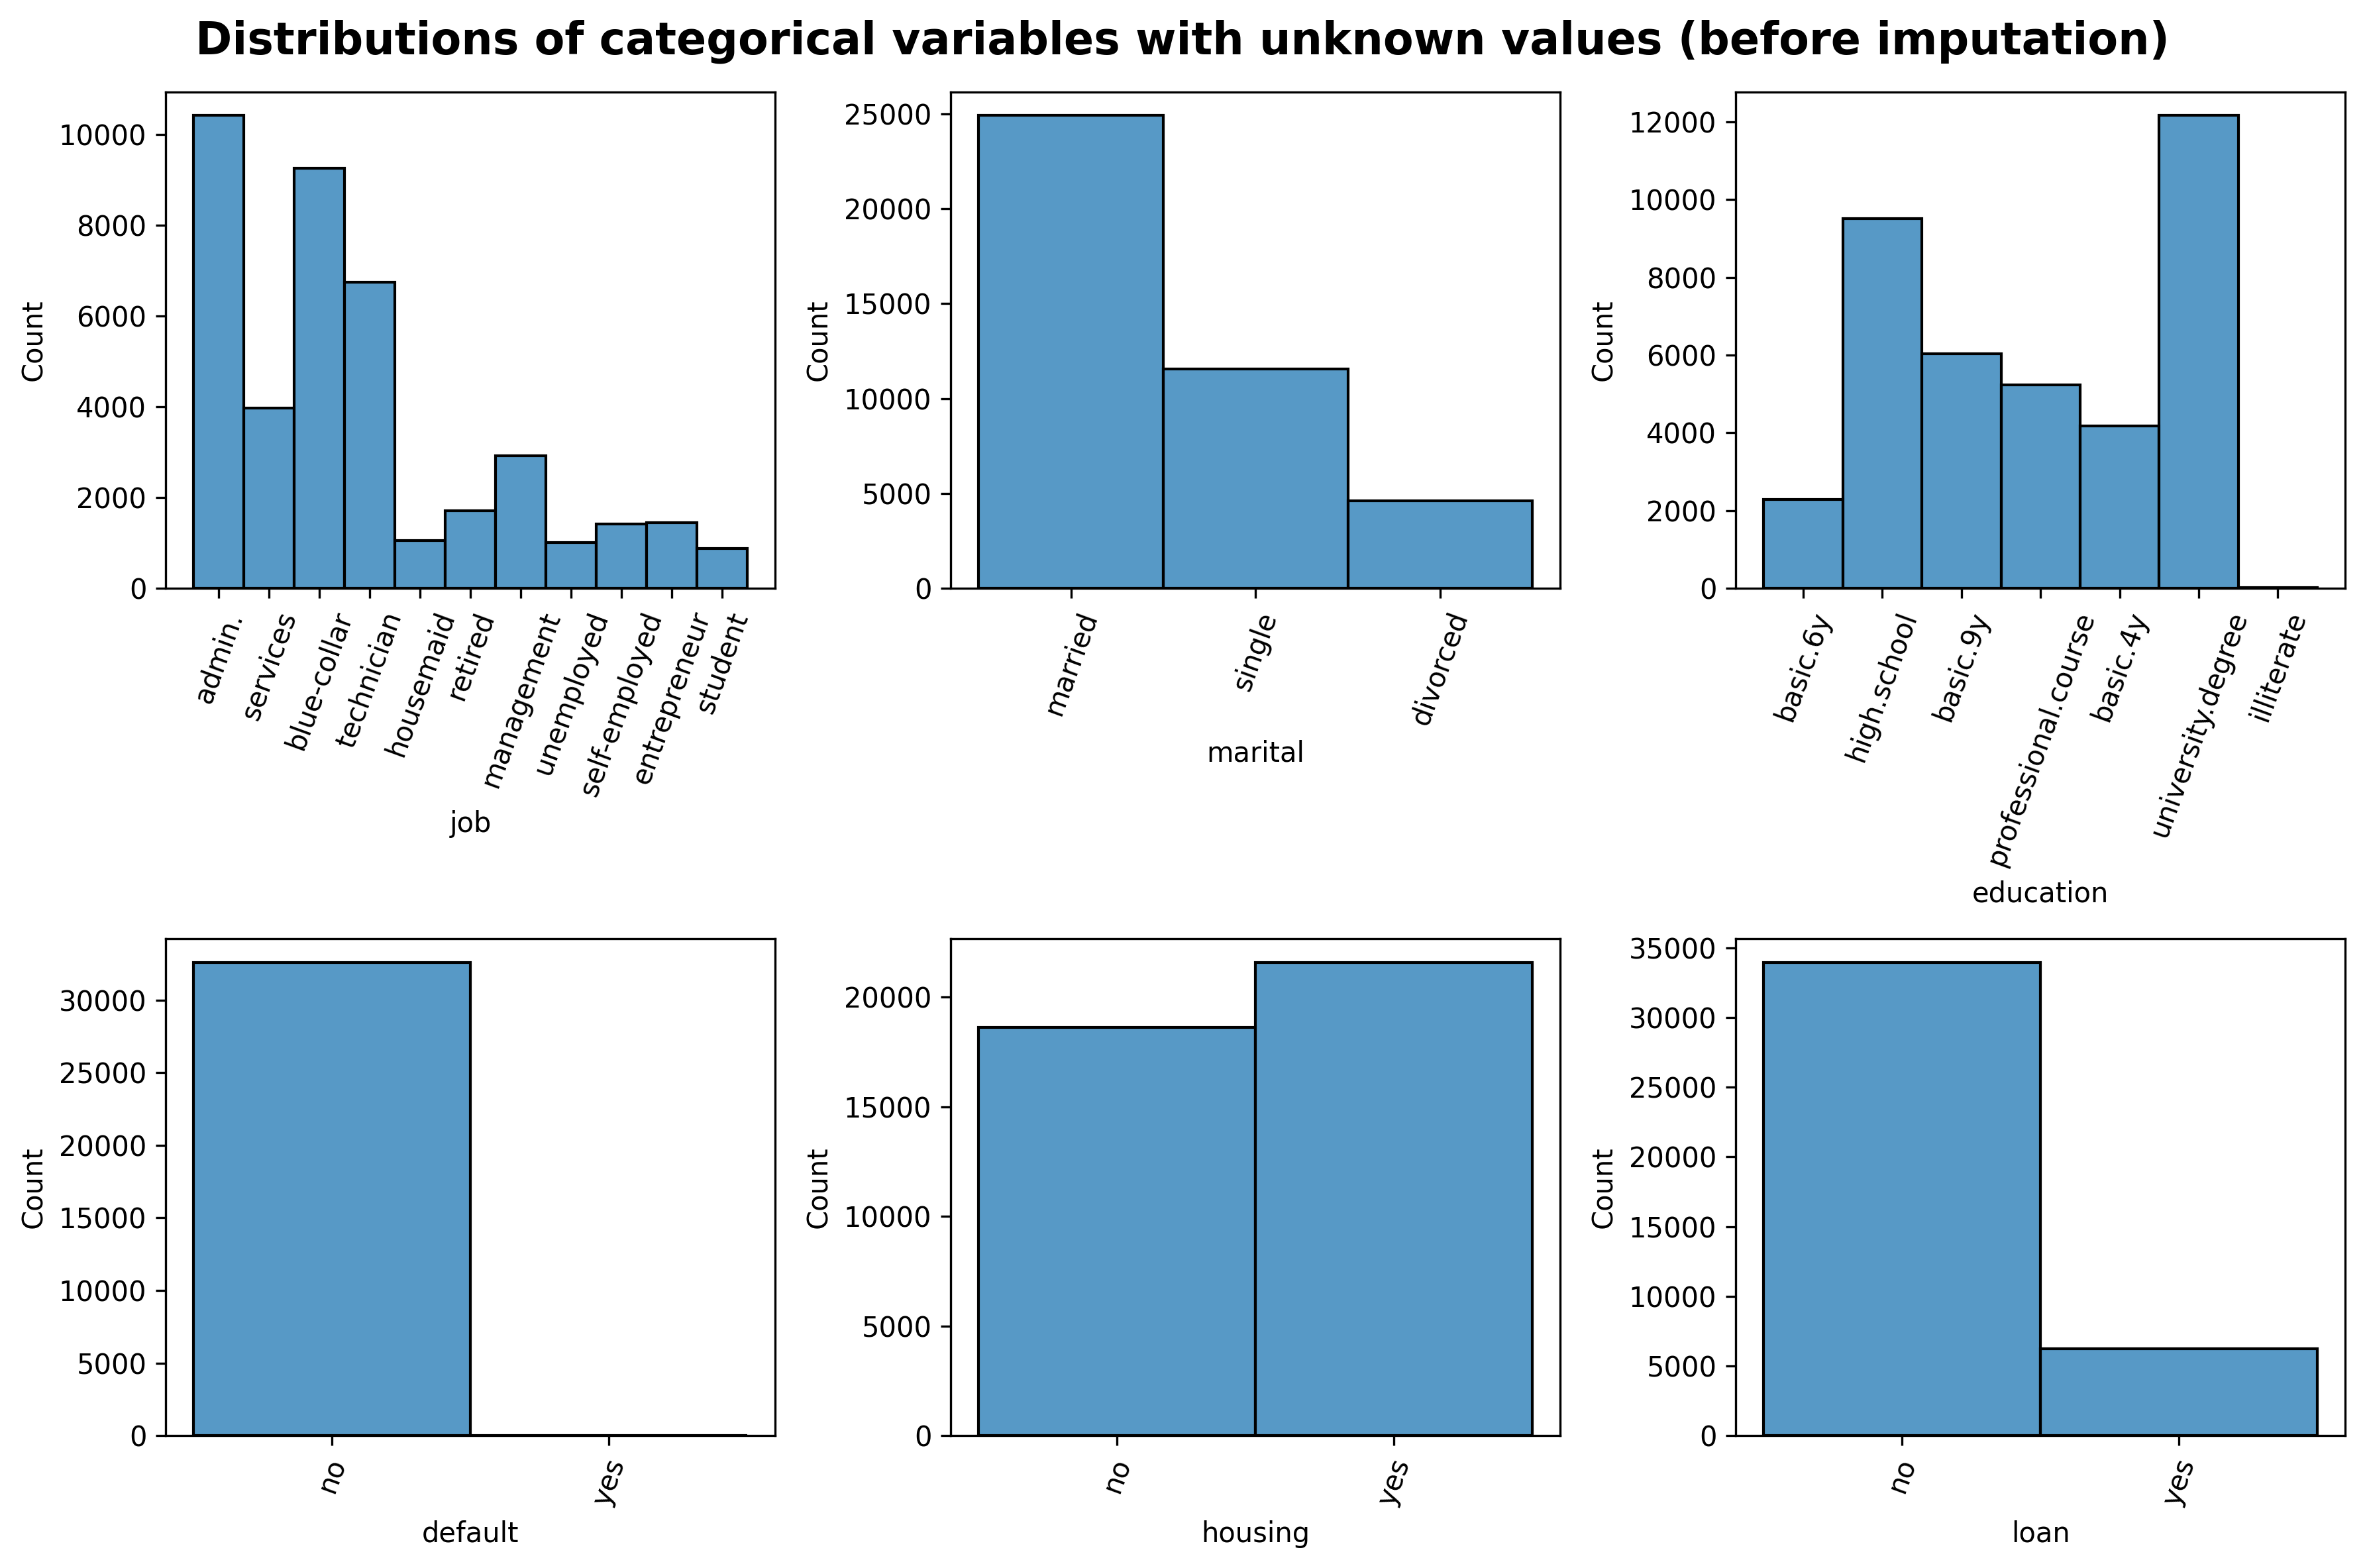

In [24]:
nan_cols = [col for col in data_cat.columns if data[col].isna().any()]

nrow, ncol = 2, 3
fig, axes = plt.subplots(nrow, ncol, figsize=(12, 8), dpi=300)

for i in range(nrow * ncol):
    try:
        ax = plt.subplot(nrow, ncol, i+1)
        sns.histplot(data=data_cat, x=nan_cols[i], ax=ax)
        ax.tick_params(axis='x', labelrotation = 70)
    except IndexError:
        break
fig.suptitle('Distributions of categorical variables with unknown values (before imputation)', weight='bold', size=16)
plt.tight_layout()
plt.show()

The strategy is to use a multivariate Bayesian imputation method, using other variables as conditional input. The estimator is a Bayesian l2-penalised regression, with the initialised value being the most frequent value in each column with NAs.

In order to use this imputer, categorical features need to be numerically encoded, so I will do that as well.

In [25]:
# Numerically encode categorical features
ord_encoder = OrdinalEncoder(
    categories="auto",
    dtype=np.float16,
    handle_unknown="error",
    encoded_missing_value=np.nan
).fit(data_cat)

In [26]:
# Encoded categorical data
data_cat_encoded = pd.DataFrame(ord_encoder.transform(data_cat), columns=ord_encoder.feature_names_in_)

In [27]:
# Full dataset as numerics, as we will be using the whole dataset as input for the imputation
full_data_encoded = pd.concat([data_num, data_cat_encoded], axis=1)

In [28]:
# Initialise the Bayesian imputer
bayes_imputer = IterativeImputer(
    missing_values=np.nan,
    max_iter=20,
    initial_strategy='most_frequent',
    random_state=RANDOM_STATE)

In [29]:
# Fit and impute
data_imputed = bayes_imputer.fit_transform(full_data_encoded)

In [30]:
# Transform the imputed data back to DataFrame format
data_imputed = pd.DataFrame(
    data_imputed, 
    columns=bayes_imputer.feature_names_in_
)

In [31]:
# Drop the non-categorical columns in order to inverse-transform the imputed data back to categorical form
data_cat_imputed_encoded = data_imputed.drop(data_num.columns, axis=1)

In [32]:
# Inverse transform
data_cat_imputed = pd.DataFrame(
    ord_encoder.inverse_transform(data_cat_imputed_encoded), 
    columns=ord_encoder.feature_names_in_
)

Now I will visualise the categorical data post-imputation.

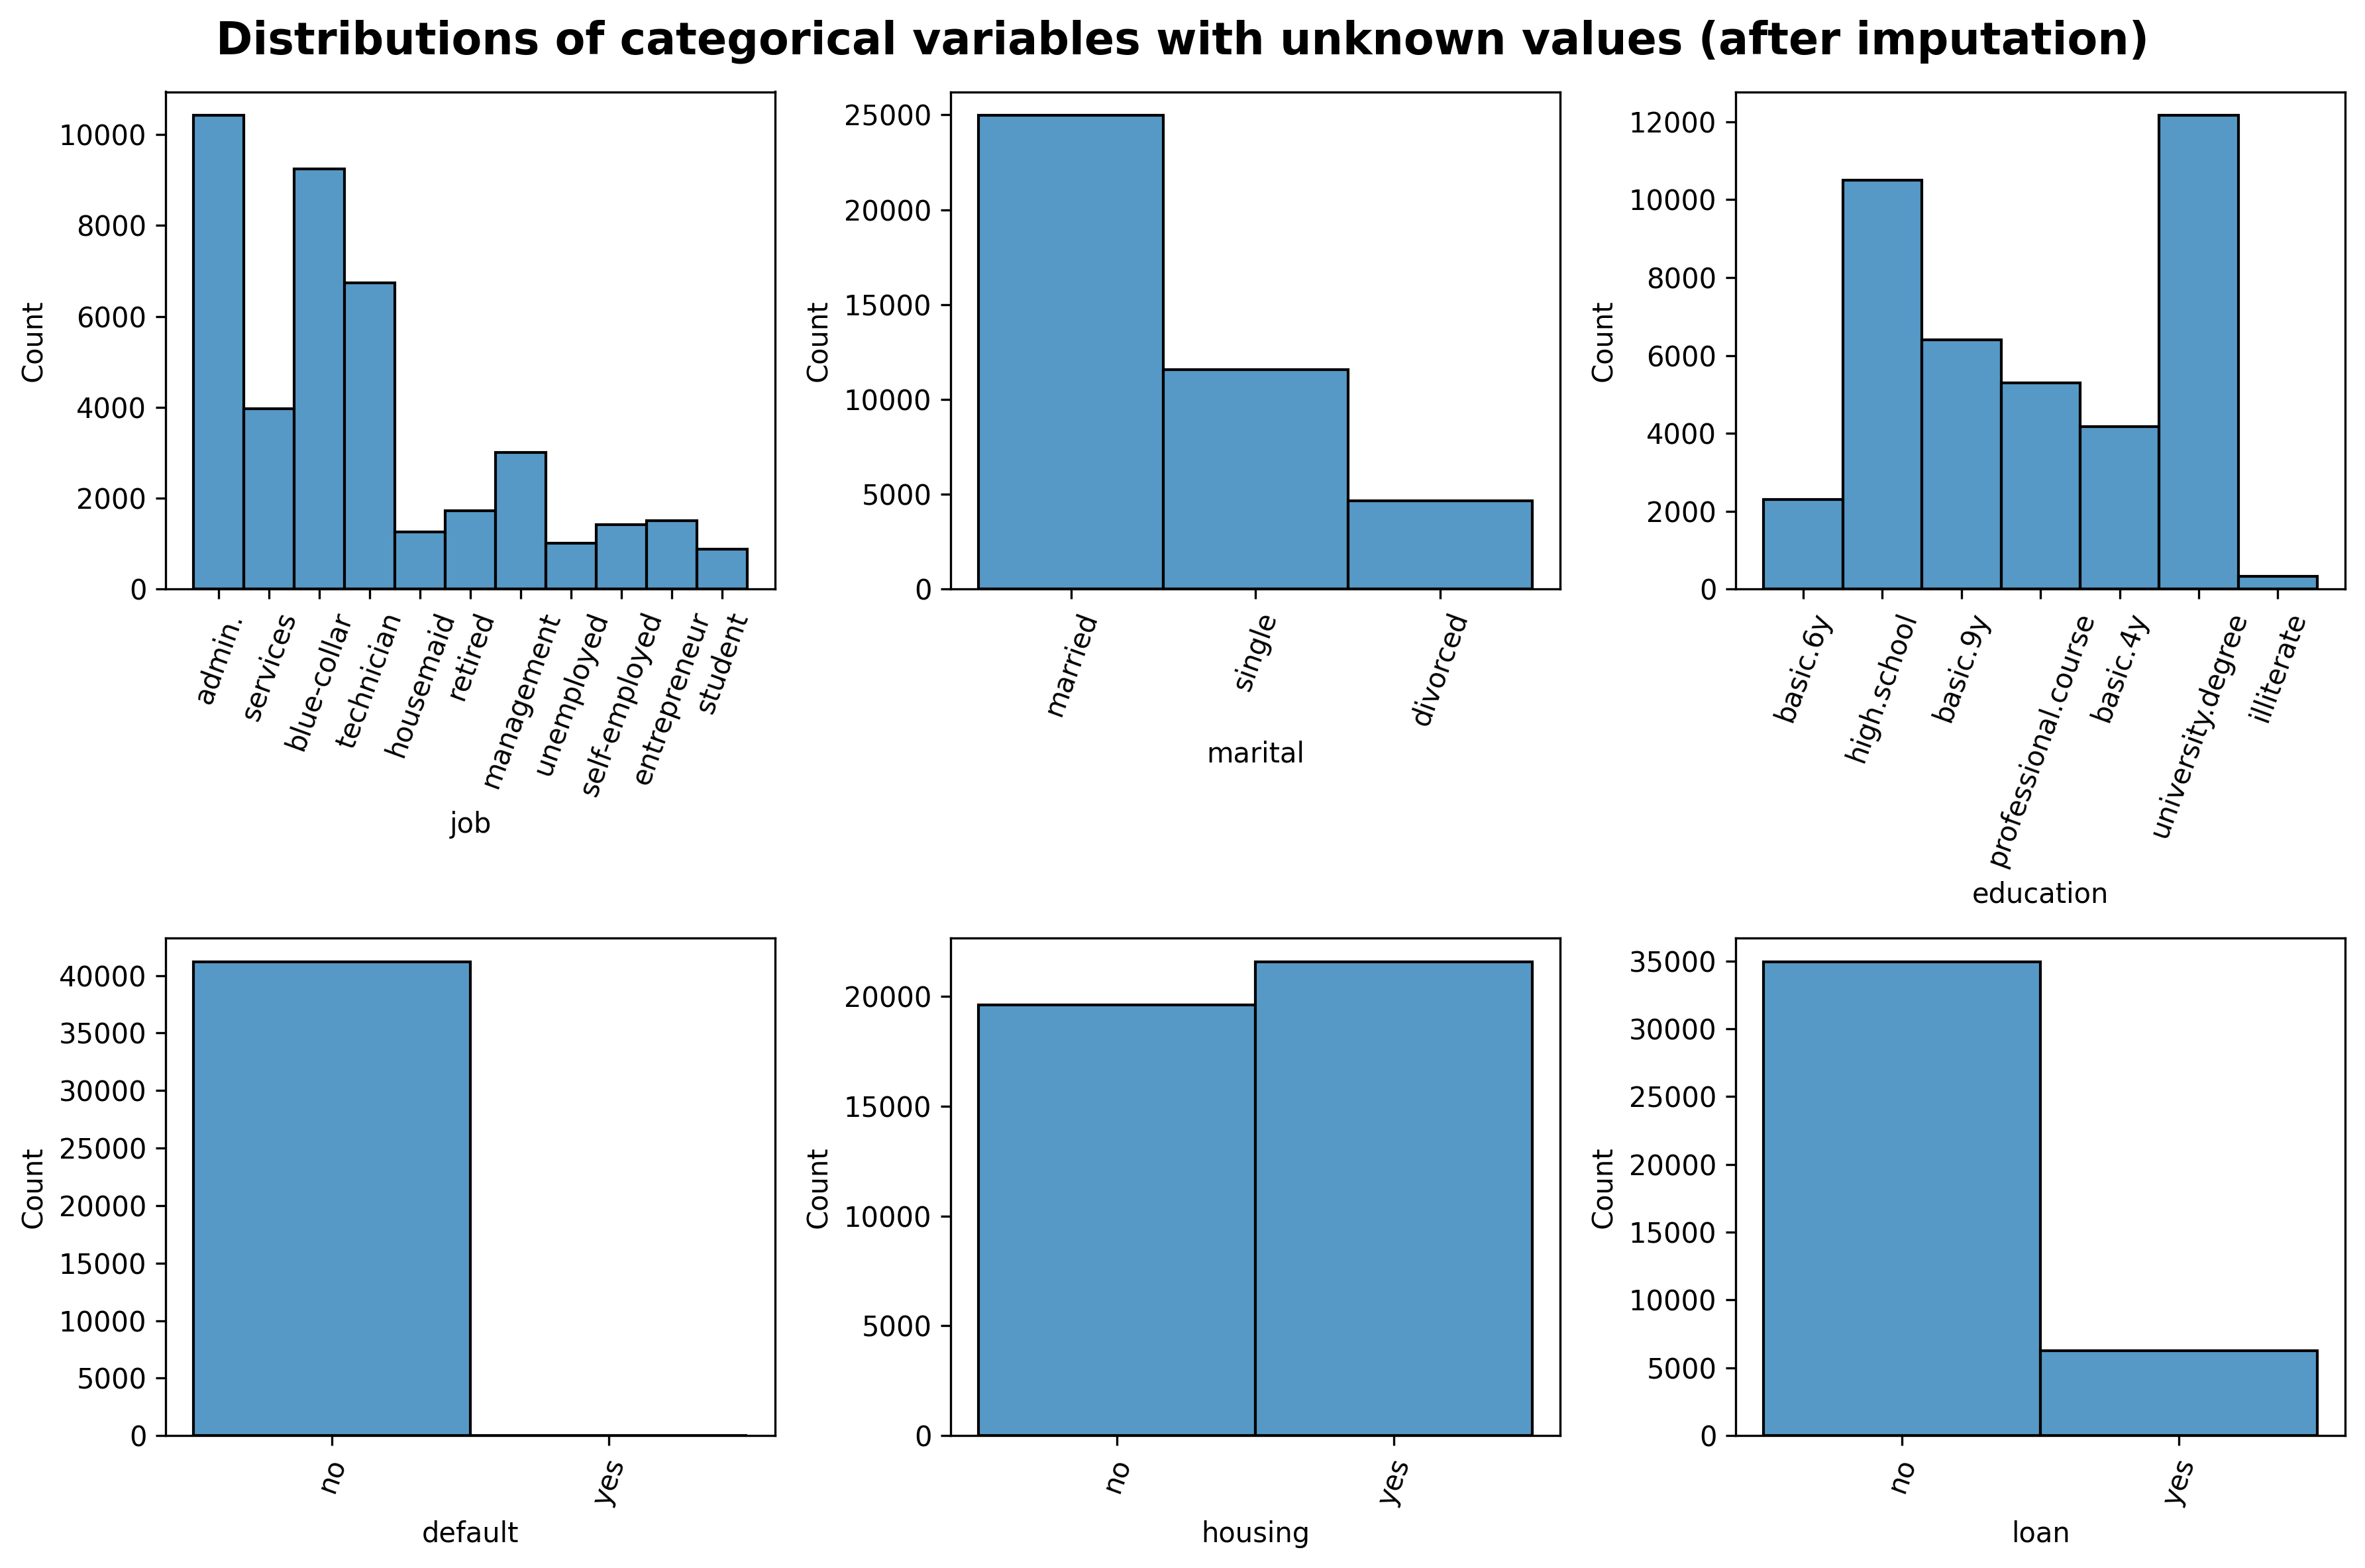

In [33]:
fig, axes = plt.subplots(nrow, ncol, figsize=(12, 8), dpi=300)

for i in range(nrow * ncol):
    try:
        ax = plt.subplot(nrow, ncol, i+1)
        sns.histplot(data=data_cat_imputed, x=nan_cols[i], ax=ax)
        ax.tick_params(axis='x', labelrotation = 70)
    except IndexError:
        break
fig.suptitle('Distributions of categorical variables with unknown values (after imputation)', weight='bold', size=16)
plt.tight_layout()
plt.show()

The distributions of all imputed columns look nearly indistinguishable from before. There are very subtle differences (e.g. the `high school` column in the `education` subplot has increased from below 10000 to above 10000).

Now I will re-concatenate the imputed data with the numerical subset in order to get back the full dataset.

In [34]:
# Re-concatenation
data = pd.concat([data_cat_imputed, data_num], axis=1)

In preparation for modelling, I will encode binary categorical variables with numbers, and dummify the rest in order to generate a series of binary variables. This will preserve the information needed from all categorical variables, so we can measure their effects later on.

In [35]:
# Manually encode binary categorical variables
data.replace({"no": 0, "yes": 1, "telephone": 1, "cellular": 2}, inplace=True)

In [36]:
# Split dataset into categorical and numerical
data_num = data.select_dtypes(exclude='object')
data_cat = data.select_dtypes(include='object')

In [37]:
# Binarise the categorical data
data_cat_dummies = pd.get_dummies(data_cat).astype(int)

In [38]:
# Check the shape of the dummified dataset
data_cat_dummies.shape

(41176, 39)

## The design matrix

In [39]:
# Concatenate the dummified dataset with the numerical subset to get the final design matrix
X = pd.concat([data_cat_dummies, data_num], axis=1)

In [40]:
# Check the first few rows
X.head()

job_admin.  job_blue-collar  job_entrepreneur  job_housemaid  \
0           1                0                 0              0   
1           0                0                 0              0   
2           0                0                 0              0   
3           1                0                 0              0   
4           0                1                 0              0   

   job_management  job_retired  job_self-employed  job_services  job_student  \
0               0            0                  0             0            0   
1               0            0                  0             1            0   
2               0            0                  0             1            0   
3               0            0                  0             0            0   
4               0            0                  0             0            0   

   job_technician  ...  age  duration  campaign  pdays  previous  \
0               0  ...   40       151         1     -1         0   
1               0  ...   56       307         1     -1         0   
2               0  ...   45       198         1     -1         0   
3               0  ...   59       139         1     -1         0   
4               0  ...   41       217         1     -1         0   

   emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed  
0           1.1          93.994          -36.4      4.857       5191.0  
1           1.1          93.994          -36.4      4.857       5191.0  
2           1.1          93.994          -36.4      4.857       5191.0  
3           1.1          93.994          -36.4      4.857       5191.0  
4           1.1          93.994          -36.4      4.857       5191.0  

[5 rows x 53 columns]

## Data splitting

Split data using a stratified split because the data is imbalanced. The test size is 20%.

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

## Data scaling

According to the scaling method proposed by Tibshirani (1997), we will be scaling the whole X matrix, including the indicator variables. This is so that we can use lasso-penalised logistic regression, which requires standardisation of all predictors. Lasso also supports feature selection, which is a means for reducing the effect of overfitting, since we have a much larger number of variables upon dummifying.

In [42]:
std_scaler = StandardScaler()

In [43]:
# Fit the training data, then transform both the training and the testing data
std_scaler.fit(X_train)
X_train_scaled = pd.DataFrame(std_scaler.transform(X_train), columns=std_scaler.feature_names_in_, index=X_train.index)
X_test_scaled = pd.DataFrame(std_scaler.transform(X_test), columns=std_scaler.feature_names_in_, index=X_test.index)

This concludes the preprocessing part necessary for statistical modelling.

# Statistical modelling

For this part, I define several utility functions:
- `search`: perform a 5-fold cross-validated randomised search on a specified parameter space of a model, and returns the best validated f1-score and the best model found
- `cv`, `get_cv_scores` and `visualise_cv_results`: assist with the visualisation of possible parameter ranges, so that a narrower and more focused search space could be navigated in order to speed up the `search` function
- `visualise_confusion_matrix`: to visualise the CV confusion matrix of the best model found using the `search` function. This matrix is needed from each model in order to compare them at the end.

In [44]:
def search( 
        estimator, 
        search_spaces, 
        X_train=X_train,
        y_train=y_train,
        cv=5, 
        n_iter=10,
        refit=True, 
        verbose=4, 
        scoring='f1', 
        random_state=RANDOM_STATE,
        print_score=True):
    """
    Performs "cv"-fold cross-validated randomised search on a specified 
    parameter space of a model, and returns the best validated 
    f1-score and the best model found.
    """
    est_name = estimator.__class__.__name__
    
    optimiser = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=search_spaces,
        cv=cv,
        n_iter=n_iter,
        refit=refit,
        verbose=verbose,
        scoring=scoring,
        random_state=random_state
    )
    optimiser.fit(X_train, y_train)
    
    best_score, best_est = optimiser.best_score_, optimiser.best_estimator_
    
    if print_score:
        print(f"--------------\nBest {cv}-fold CV score for {est_name}: {best_score:.6f}\n--------------")
    
    return best_score, best_est

In [45]:
def cv(estimator, X=X_train, y=y_train, cv=5, return_scores=False, return_confusion_matrix_and_predictions=False):
    """
    Calculates the train and validation scores for an estimator, for a single fit.
    """
    
    assert return_scores ^ return_confusion_matrix_and_predictions, 'Return one of the result sets only.'
    
    # Define a StratifiedKFold object, and initiate train and test scores list if requested
    if return_scores:
        str_k_fold = StratifiedKFold(n_splits=2, shuffle=False)
        train_scores, test_scores = [], []
    if return_confusion_matrix_and_predictions:
        str_k_fold = StratifiedKFold(n_splits=cv, shuffle=False)
        y_pred = np.zeros(y.shape)
    
    # Iterate through the folds
    for train_i, test_i in str_k_fold.split(X, y):
        X_train_cv, X_test_cv, y_train_cv, y_test_cv = X.iloc[train_i], X.iloc[test_i], y.iloc[train_i], y.iloc[test_i]
        estimator.fit(X_train_cv, y_train_cv)
        y_pred_cv = estimator.predict(X_test_cv)
        
        if return_confusion_matrix_and_predictions:
            y_pred[test_i] = y_pred_cv
        
        if return_scores:
            y_train_pred_cv = estimator.predict(X_train_cv)
            train_scores.append(f1_score(y_train_cv, y_train_pred_cv))
            test_scores.append(f1_score(y_test_cv, y_pred_cv))
            
    if return_confusion_matrix_and_predictions:
        conf_matx = confusion_matrix(y, y_pred)
        return conf_matx, y_pred
    
    if return_scores:
        mean_train_score = sum(train_scores)/len(train_scores)
        mean_val_score = sum(test_scores)/len(test_scores)
        return mean_train_score, mean_val_score


def get_cv_scores(estimator, param_space, X_train=X_train, y_train=y_train, verbose=True):
    """
    Gathers the results of the cv function across different 
    parameter settings of an estimator.
    """
    
    params_orig = estimator.get_params()
    params = param_space.keys()
    results = {}
    for param in params:
        value_arr, train_arr, val_arr = [], [], []
        for value in param_space[param]:
            param_this_run = {param: value}
            estimator.set_params(**param_this_run)
            train_score, val_score = cv(
                estimator=estimator,
                X=X_train,
                y=y_train,
                return_scores=True
            )
            value_arr.append(value)
            train_arr.append(train_score)
            val_arr.append(val_score)
            
            if verbose:
                print(f'Fitting "{param}" = {value}')
        
        # Append results to dict
        results[param] = {
            'value': value_arr,
            'train_score': train_arr,
            'val_score': val_arr
        }
        
        # Reset params to original for the next run
        estimator.set_params(**params_orig)
    
    return results
    
    
def visualise_cv_results(estimator, results: dict):
    """
    Visualise the cross-validation results for a model, 
    including the parameter range tested and the 
    train/validation scores.
    """
    params = results.keys()
    cols = 2
    rows = len(results) // 2 + 1
    
    fig = plt.figure(figsize=(8, int(rows*3)), dpi=200)
    for i, param in enumerate(params):
        param_values = results[param]['value']
        if None in param_values:
            param_values[param_values.index(None)] = 'None'
        df = pd.DataFrame(results[param], columns=results[param].keys(), index=param_values).drop('value', axis=1)
        ax = fig.add_subplot(rows, cols, i+1)
        sns.lineplot(data=df)
        if param == 'C':
            ax.set(xscale='log')
        ax.set_xlabel(param)
        ax.set_ylabel('f1 score')
    
    fig.suptitle(f'Train and validation scores of different hyperparameters,\n{estimator.__class__.__name__}')    
    fig.tight_layout()
    fig.show()
    
    
def visualise_confusion_matrix(estimator, X=X_train, y=y_train, norm=True, return_results=True):
    """
    Visualise the cross-validation confusion matrix.
    """
    conf_matx, y_pred_cv = cv(estimator, X=X, y=y, return_confusion_matrix_and_predictions=return_results)
    # If norm=True, normalise the confusion matrix and display it
    if norm:
        tn_rate = conf_matx[0, 0] / (conf_matx[0, 0] + conf_matx[0, 1])
        fp_rate = 1.0 - tn_rate
        tp_rate = conf_matx[1, 1] / (conf_matx[1, 1] + conf_matx[1, 0])
        fn_rate = 1.0 - tp_rate
    
        conf_matx_norm = np.array([[tn_rate, fp_rate], [fn_rate, tp_rate]])
    
        display = ConfusionMatrixDisplay(conf_matx_norm, display_labels=estimator.classes_)
        display.plot(values_format='.4f')
    
    # If norm=False, display the unnormalised version
    elif not norm:
        display = ConfusionMatrixDisplay(conf_matx, display_labels=estimator.classes_)
        display.plot(values_format='.0f')   
        
    if return_results:
        return conf_matx, y_pred_cv

## Logistic regression

Logistic regression (LR) is a generalised linear model, which is a straightforward statistical model with a nice interpretation of coefficients. We will be using Lasso penalised LR to make use of its variable selection advantage.

The underlying machinery of this LR is a maximum likelihood estimation (MLE) of the regression coefficient over the Lasso-penalised negative log-likelihood (scikit-learn, 2023):

$$\min_{\boldsymbol{\beta}} z = \sum_{i=1}^n \big[- y_i \ln(\hat{p}(\mathbf{x}_i)) - (1-y_i)\ln(1 - \hat{p}(\mathbf{x}_i))\big] + \lambda\Vert\boldsymbol{\beta}\Vert_1$$

Since there are no closed-form solutions for logistic regression, we resort to an iterative optimisation algorithm. In this case, a version of the Stochastic Average Gradient (SAG) algorithm called SAGA was used, which accommodates the Lasso penalty.

In [46]:
# Define the estimator and the search space
lr = LogisticRegression(
    penalty='l1',
    max_iter=500,
    solver='saga',
    random_state=RANDOM_STATE
)

lr_hp_space = {
    'C': [1e-4, 1e-3, 1e-2, 1e-1, 1e1, 1e2, 1e3, 1e4],
    'class_weight': [None, 'balanced']
}

In [47]:
# Scaled X_train
lr_res = get_cv_scores(lr, lr_hp_space, X_train=X_train_scaled)

Fitting "C" = 0.0001
Fitting "C" = 0.001
Fitting "C" = 0.01
Fitting "C" = 0.1
Fitting "C" = 10.0
Fitting "C" = 100.0
Fitting "C" = 1000.0
Fitting "C" = 10000.0
Fitting "class_weight" = None
Fitting "class_weight" = balanced


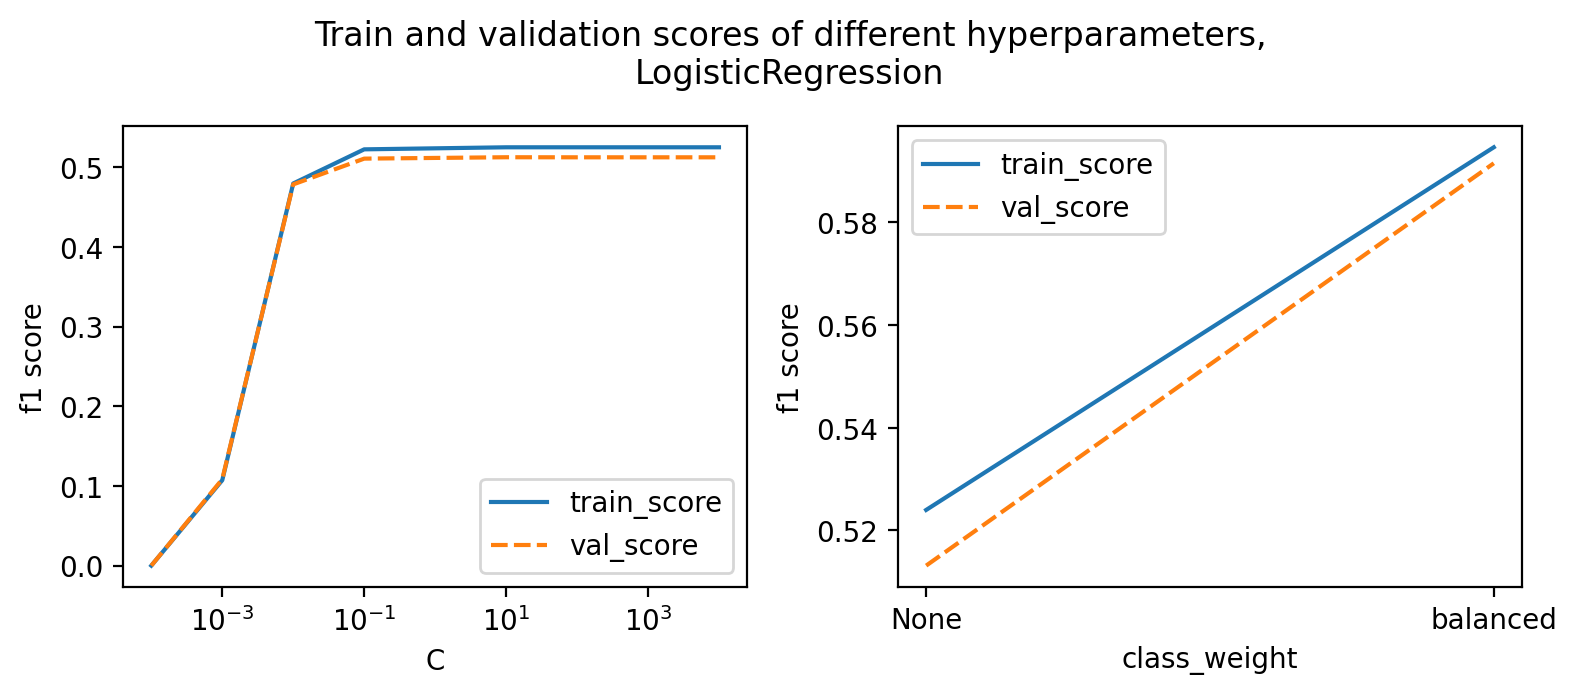

In [48]:
visualise_cv_results(lr, lr_res)

In [49]:
# Define the reduced search space for randomised search
lr_reduced_hp_space = {
    'C': np.logspace(-2, 1, 4),
    'class_weight': ['balanced']
}

In [50]:
# Search using scaled X_train
lr_score, lr_best_model = search(
    estimator=lr,
    search_spaces=lr_reduced_hp_space,
    X_train=X_train_scaled,
    n_iter=4
)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END .....C=0.01, class_weight=balanced;, score=0.596 total time=   1.2s
[CV 2/5] END .....C=0.01, class_weight=balanced;, score=0.582 total time=   1.1s
[CV 3/5] END .....C=0.01, class_weight=balanced;, score=0.581 total time=   1.3s
[CV 4/5] END .....C=0.01, class_weight=balanced;, score=0.595 total time=   1.2s
[CV 5/5] END .....C=0.01, class_weight=balanced;, score=0.588 total time=   1.3s
[CV 1/5] END ......C=0.1, class_weight=balanced;, score=0.599 total time=   8.2s
[CV 2/5] END ......C=0.1, class_weight=balanced;, score=0.587 total time=   7.1s
[CV 3/5] END ......C=0.1, class_weight=balanced;, score=0.590 total time=   7.0s
[CV 4/5] END ......C=0.1, class_weight=balanced;, score=0.602 total time=   7.3s
[CV 5/5] END ......C=0.1, class_weight=balanced;, score=0.589 total time=   7.2s
[CV 1/5] END ......C=1.0, class_weight=balanced;, score=0.599 total time=   7.1s
[CV 2/5] END ......C=1.0, class_weight=balanced;,

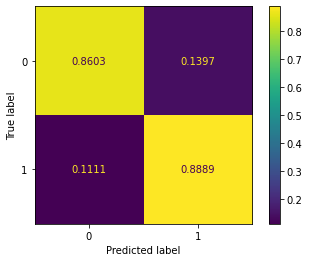

In [51]:
lr_confusion_matrix_cv, lr_y_pred_cv = visualise_confusion_matrix(lr_best_model, X=X_train_scaled)

In [52]:
lr_best_model

LogisticRegression(class_weight='balanced', max_iter=500, penalty='l1',
                   random_state=11919925, solver='saga')

## K-Neighbour Classifier

In [53]:
knn = KNeighborsClassifier(
    metric='minkowski',
    p=2,
    algorithm='auto'
)

knn_hp_space = {
    'n_neighbors': np.arange(50, 501,10),
    'weights': ['uniform', 'distance']
}

In [54]:
# Non-scaled X_train
knn_res = get_cv_scores(knn, knn_hp_space)

Fitting "n_neighbors" = 50
Fitting "n_neighbors" = 60
Fitting "n_neighbors" = 70
Fitting "n_neighbors" = 80
Fitting "n_neighbors" = 90
Fitting "n_neighbors" = 100
Fitting "n_neighbors" = 110
Fitting "n_neighbors" = 120
Fitting "n_neighbors" = 130
Fitting "n_neighbors" = 140
Fitting "n_neighbors" = 150
Fitting "n_neighbors" = 160
Fitting "n_neighbors" = 170
Fitting "n_neighbors" = 180
Fitting "n_neighbors" = 190
Fitting "n_neighbors" = 200
Fitting "n_neighbors" = 210
Fitting "n_neighbors" = 220
Fitting "n_neighbors" = 230
Fitting "n_neighbors" = 240
Fitting "n_neighbors" = 250
Fitting "n_neighbors" = 260
Fitting "n_neighbors" = 270
Fitting "n_neighbors" = 280
Fitting "n_neighbors" = 290
Fitting "n_neighbors" = 300
Fitting "n_neighbors" = 310
Fitting "n_neighbors" = 320
Fitting "n_neighbors" = 330
Fitting "n_neighbors" = 340
Fitting "n_neighbors" = 350
Fitting "n_neighbors" = 360
Fitting "n_neighbors" = 370
Fitting "n_neighbors" = 380
Fitting "n_neighbors" = 390
Fitting "n_neighbors" = 4

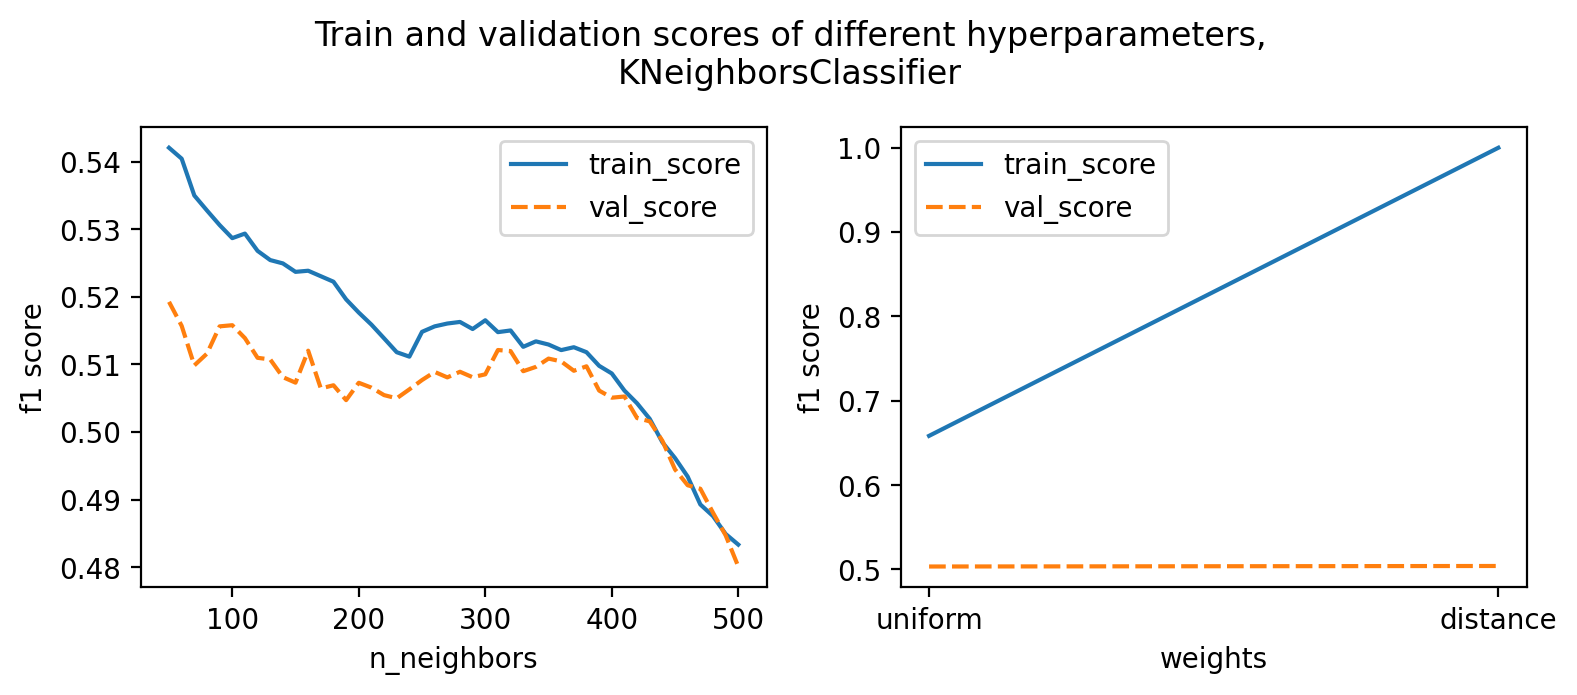

In [55]:
visualise_cv_results(knn, knn_res)

In [56]:
knn_reduced_hp_space = {
    'n_neighbors': np.arange(50, 171, 10),
    'weights': ['uniform', 'distance']
}

In [57]:
# Non-scaled X_train
knn_score, knn_best_model = search(
    estimator=knn,
    search_spaces=knn_reduced_hp_space,
    verbose=0
)

--------------
Best 5-fold CV score for KNeighborsClassifier: 0.541354
--------------


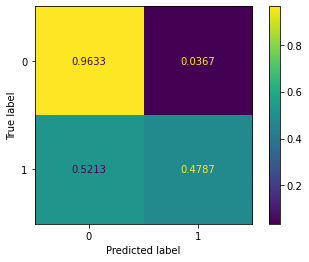

In [58]:
knn_confusion_matrix_cv, knn_y_pred_cv = visualise_confusion_matrix(knn_best_model)

In [59]:
knn_best_model

KNeighborsClassifier(n_neighbors=50, weights='distance')

## Decision Tree Classifier

In [60]:
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)

In [61]:
dt_hp_space = {
    'max_depth': np.arange(10, 51, 2),
    'min_samples_split': np.arange(10, 1001, 10),
    'min_samples_leaf': np.arange(10, 1001, 10),
    'max_features': np.arange(1, int(np.ceil(np.sqrt(X_train.shape[1])))),
    'class_weight': [None, 'balanced']
}

In [62]:
# Non-scaled X_train
dt_res = get_cv_scores(dt, dt_hp_space, verbose=False)

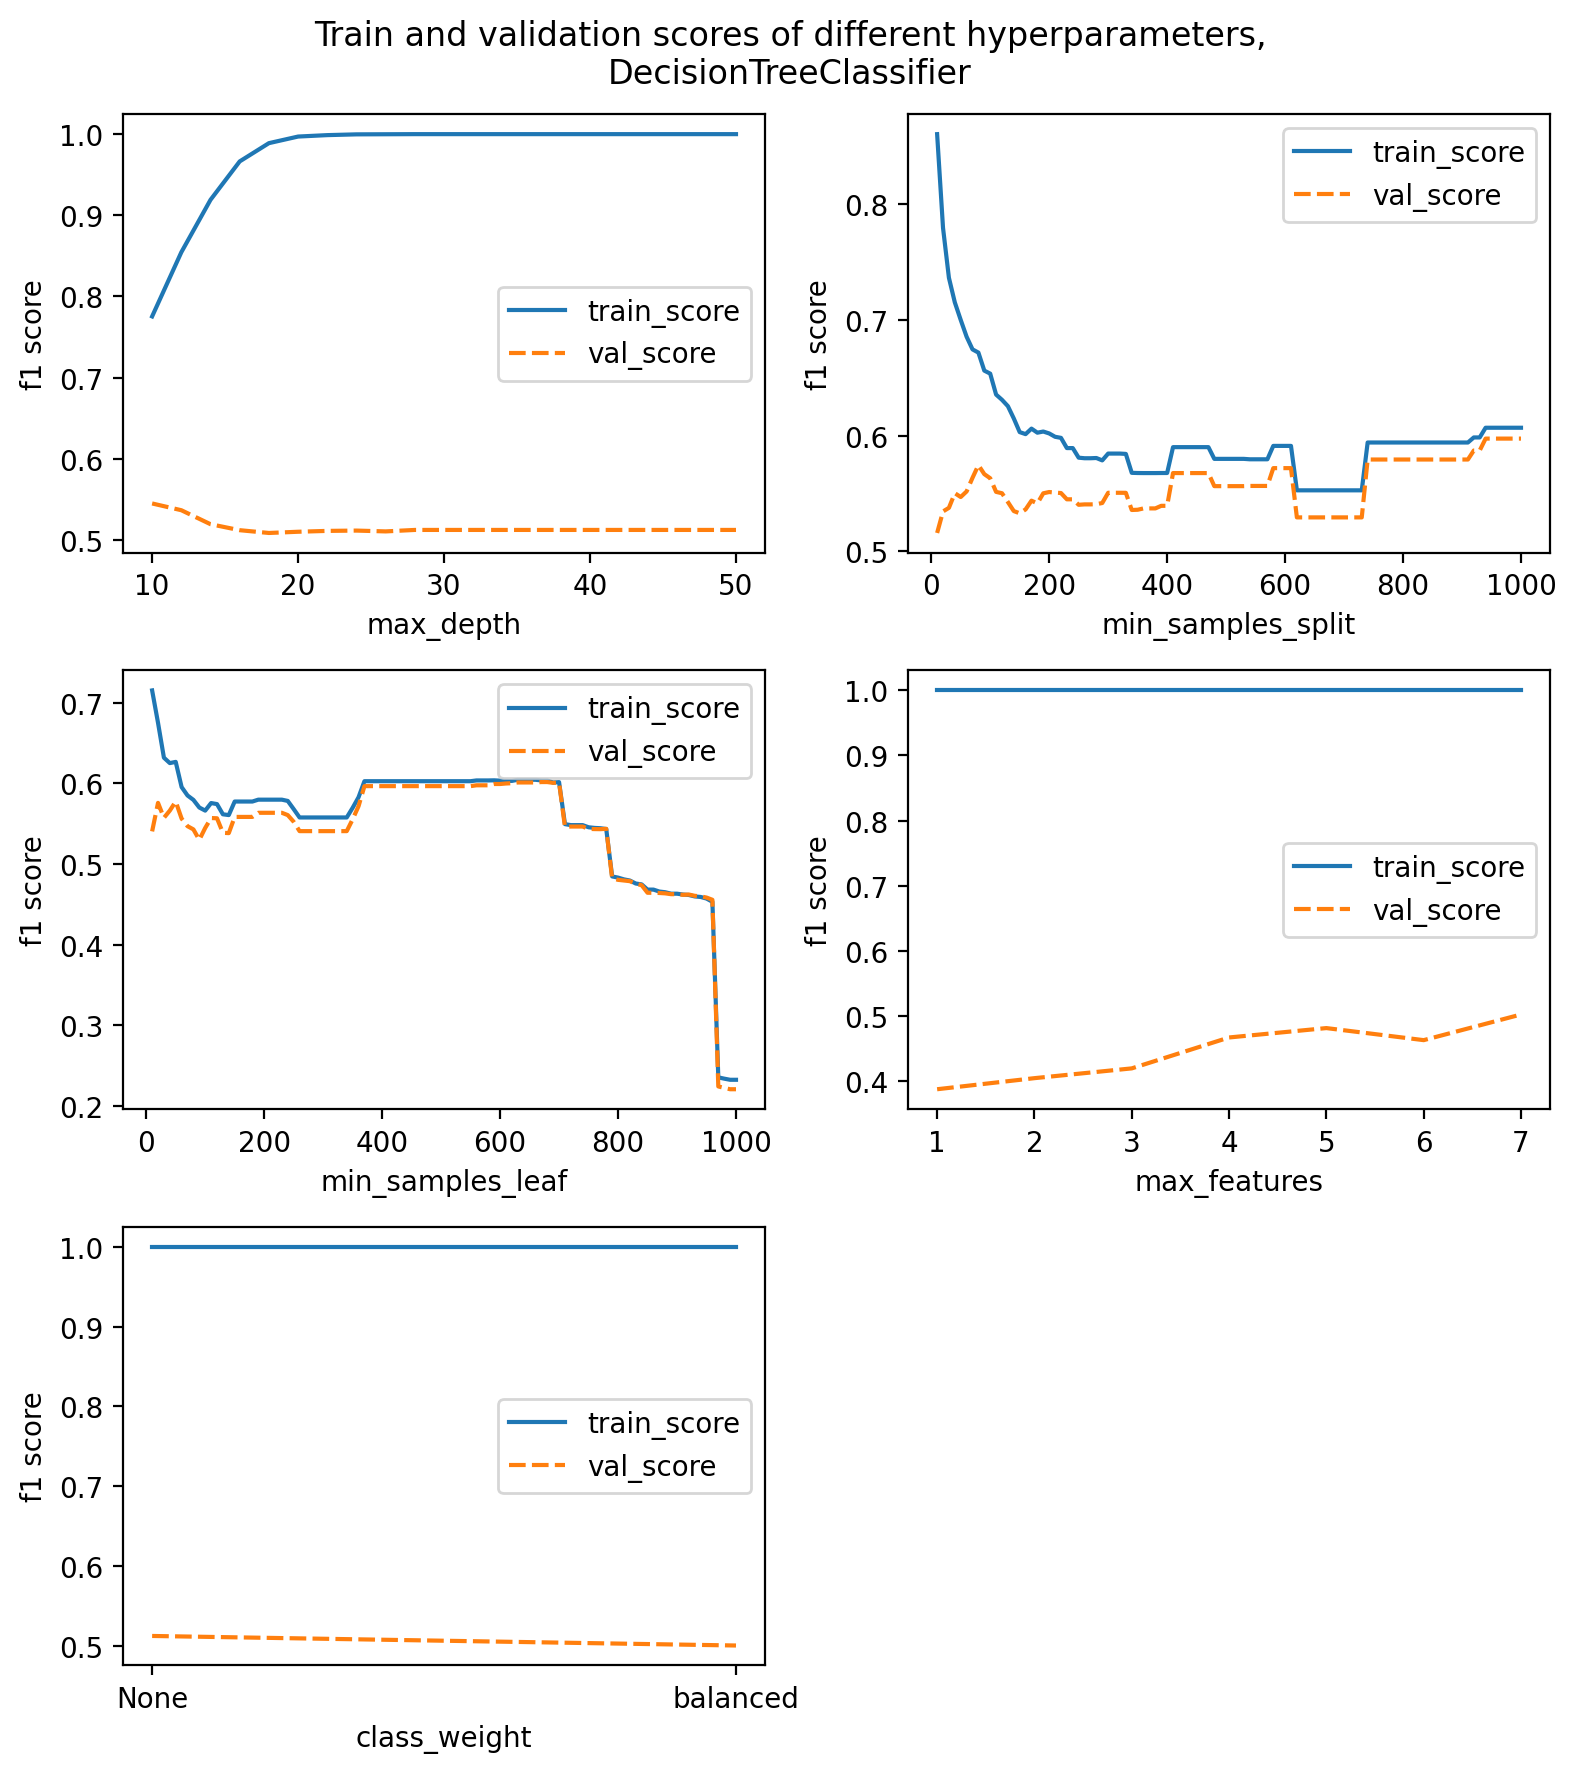

In [63]:
visualise_cv_results(dt, dt_res)

In [64]:
dt_reduced_hp_space = {
    'max_depth': np.arange(10, 25, 2),
    'min_samples_split': np.arange(600, 1001, 10),
    'min_samples_leaf': np.arange(400, 700, 10),
    'max_features': [3, 4, 5, 6, 7],
    'class_weight': ['balanced']
}

In [65]:
# Non-scaled X_train
dt_score, dt_best_model = search(
    estimator=dt,
    search_spaces=dt_reduced_hp_space,
    n_iter=100,
    verbose=0
)

--------------
Best 5-fold CV score for DecisionTreeClassifier: 0.517823
--------------


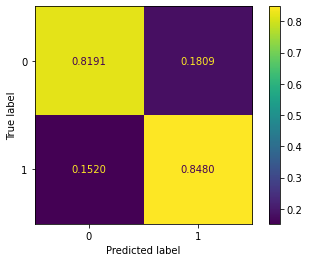

In [66]:
dt_confusion_matrix_cv, dt_y_pred_cv = visualise_confusion_matrix(dt_best_model)

In [67]:
dt_best_model

DecisionTreeClassifier(class_weight='balanced', max_depth=22, max_features=7,
                       min_samples_leaf=660, min_samples_split=970,
                       random_state=11919925)

## Random Forest Classifier

In [68]:
dt_best_params = {key: dt_best_model.get_params()[key] for key in dt_reduced_hp_space.keys()}

rf = RandomForestClassifier(random_state=RANDOM_STATE).set_params(**dt_best_params)

rf_hp_space = {
    'n_estimators': np.arange(10, 201, 10),
    'class_weight': ['balanced', 'balanced_subsample']
}

In [69]:
# Non-scaled X_train
rf_res = get_cv_scores(rf, rf_hp_space)

Fitting "n_estimators" = 10
Fitting "n_estimators" = 20
Fitting "n_estimators" = 30
Fitting "n_estimators" = 40
Fitting "n_estimators" = 50
Fitting "n_estimators" = 60
Fitting "n_estimators" = 70
Fitting "n_estimators" = 80
Fitting "n_estimators" = 90
Fitting "n_estimators" = 100
Fitting "n_estimators" = 110
Fitting "n_estimators" = 120
Fitting "n_estimators" = 130
Fitting "n_estimators" = 140
Fitting "n_estimators" = 150
Fitting "n_estimators" = 160
Fitting "n_estimators" = 170
Fitting "n_estimators" = 180
Fitting "n_estimators" = 190
Fitting "n_estimators" = 200
Fitting "class_weight" = balanced
Fitting "class_weight" = balanced_subsample


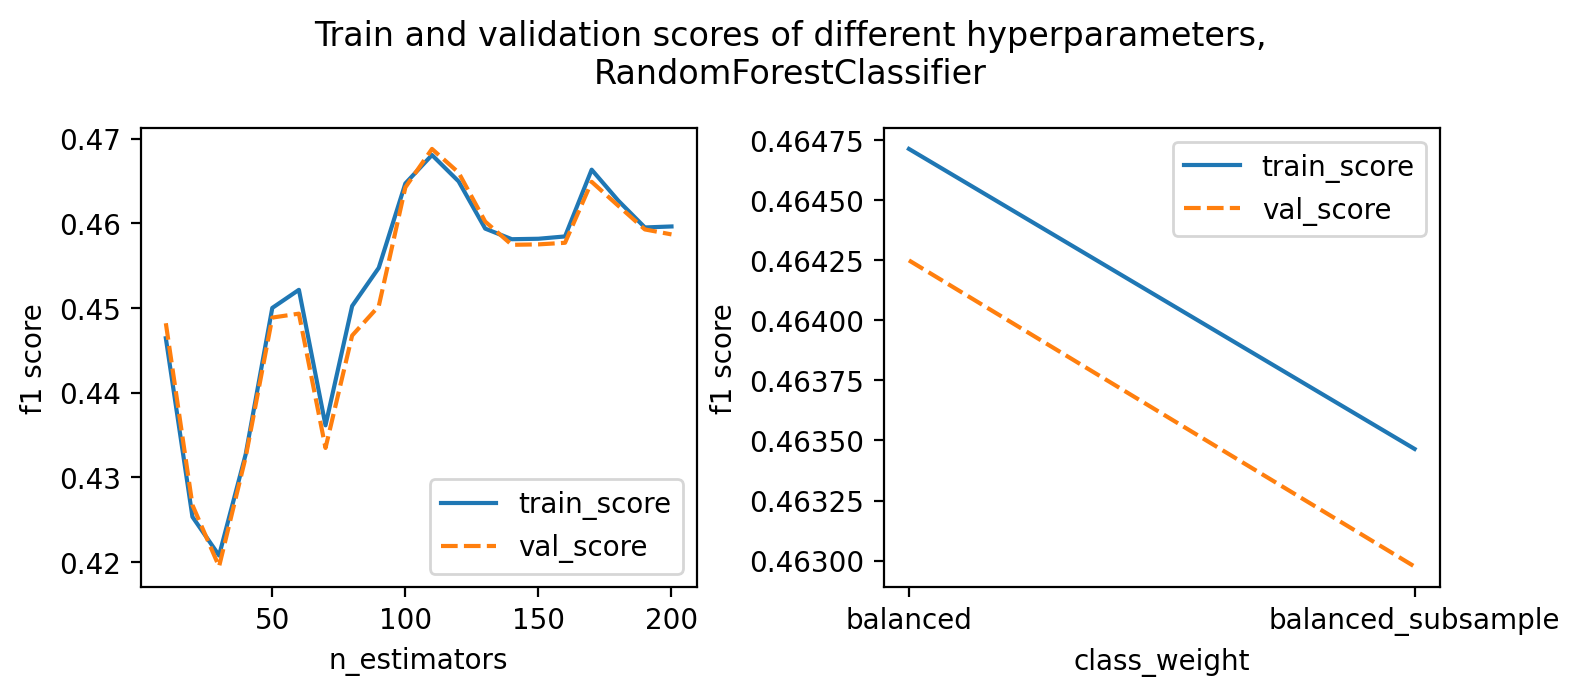

In [70]:
visualise_cv_results(rf, rf_res)

In [71]:
rf_reduced_hp_space = {
    'n_estimators': np.arange(100, 171, 10),
    'class_weight': ['balanced']
}

In [72]:
rf_score, rf_best_model = search(
    estimator=rf,
    search_spaces=rf_reduced_hp_space,
    n_iter=100,
    verbose=0
)

--------------
Best 5-fold CV score for RandomForestClassifier: 0.495596
--------------


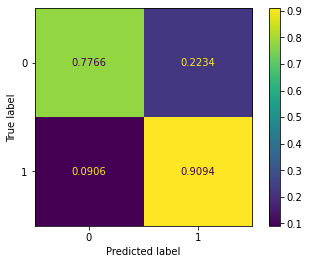

In [73]:
rf_confusion_matrix_cv, rf_y_pred_cv = visualise_confusion_matrix(rf_best_model)

In [74]:
rf_best_model

RandomForestClassifier(class_weight='balanced', max_depth=22, max_features=7,
                       min_samples_leaf=660, min_samples_split=970,
                       n_estimators=110, random_state=11919925)

# Live campaign simulation: Choosing between winning models

## The goal

The goal is to identify customers most likely to subscribe to a new telecom plan. In building the models, there are two sets of goals:

- Technical goal: to obtain a model with the highest f1-score, which is a balance between precision and recall;
- Business goal: to maximise the number of onboarding customers, which is the same as maximising recall on the technical side.

## The evaluation: campaign simulation

- Logistic Regression has the highest f1-score, but not the highest recall
- KNN has the second highest f1-score, but mainly contributed by true negatives (those accurately predicted as not interested), so will not be of interest to business
- Decision Tree came third in f1-score, and lower recall than Logistic Regression, so will not be considered. Mainly trained in preparation for ensemble learning later on
- Random Forest came last in f1-score, but highest recall of all models

Logistic Regression and Random Forest are close in performance, so there is the question of whether to choose a well-rounded model (i.e. Logistic Regression) or one that compromises precision for a higher recall (i.e. Random Forest). They will be put to the test in real campaign settings to see which model is the most profitable, and to see if a 2% improvement in true positives by the Random Forest is worth choosing over Logistic Regression, considering the fact that wasted costs of targeting the wrong people may also be significant. Assume the following yearly costs for an inbound telemarketing campaign, which is a realistic case for this dataset. The landline services are offered by **Cadiz3**, which is a market competitive company:

- Fixed rate: \$600/12 months minimum total cost
- Call rates: 10c/min telephone, 25c/min mobile. All rates are ceil rates (calls less than a minute are charged for a full minute)
- Since call durations are available, all customers are assumed to have picked up the call
- There are no other costs, for simplicity

Also, assume the telecom plan to sell is a **nbn25** plan from Optus, which is a base telecom plan:
- If customer onboard is successful: the customer may stay for a variable number of months. The plan cost is \\$70 per month, charged month-to-month. Modem charge is a fixed cost of \\$252 if customers stay for less than 36 months, and free if they stay for 36 months or more. The number of months, $x$, assuming to be continuous, has a Gamma distribution with shape $\alpha = 6$ and scale $\frac{1}{\beta} = 6$. This is a distribution with a theoretical mean $$\mathbb{E}\big[x_{Gamma} \big] = \frac\alpha\beta = 36$$ to reflect the fact that a customer would most likely want to stay in a plan for 3 years so that they don't have to pay for the modem upfront. It has longer tails than a Poisson distribution, which accommodates for those that may stay for less than 12 months, or much more than 36 months.

In [75]:
# Extract predictions from the 2 models
lr_y_pred_cv_series = pd.Series(lr_y_pred_cv, name='y_pred_LR', index=y_train.index).astype(int)
rf_y_pred_cv_series = pd.Series(rf_y_pred_cv, name='y_pred_RF', index=y_train.index).astype(int)

In [76]:
# Gather the simulation data
data_simulation = pd.concat(
    [
        X_train[['contact', 'duration']],
        y_train,
        lr_y_pred_cv_series,
        rf_y_pred_cv_series
    ], axis=1
)

In [77]:
# Create separate simulation datasets for the two models
lr_mask = data_simulation['y_pred_LR'] == 1
rf_mask = data_simulation['y_pred_RF'] == 1

lr_simu = data_simulation[lr_mask].drop(['y_pred_RF', 'y_pred_LR'], axis=1)
rf_simu = data_simulation[rf_mask].drop(['y_pred_RF', 'y_pred_LR'], axis=1)

In [78]:
lr_simu.head()

contact  duration  y
33551        2       692  0
27744        2        41  0
8760         1       870  0
34210        2      1309  0
18846        2       629  0

In [79]:
rf_simu.head()

contact  duration  y
35288        2       411  0
28394        2        71  0
33551        2       692  0
27744        2        41  0
8760         1       870  0

In [80]:
# Create a list containing the simulation datasets, for looping
simu_list = [lr_simu, rf_simu]

In [81]:
def calculate_profits(simu_df_list, cost_tele=0.10, cost_mobile=0.25, cost_fixed=600, gam_shape=6, gam_scale=6):
    profits = []
    for df in simu_df_list:
        df['cost'] = np.where(
            df['contact'] == 1, 
            cost_tele * np.ceil(df['duration']/60),
            cost_mobile * np.ceil(df['duration']/60)
        )
        np.random.seed(RANDOM_STATE)
        df['months_stayed'] = np.random.gamma(gam_shape, gam_scale, len(df)) * df['y']
        df['stayedLessThan36Mths'] = np.where(df['months_stayed'] < 36, 1, 0)
        df['months_stayed'] = np.where(
            df['months_stayed'] >= 12,
            12,
            np.ceil(df['months_stayed'])
        )
        df['revenue'] = df['y'] * (70 * df['months_stayed'] + df['stayedLessThan36Mths'] * 252)
    
        total_costs = df['cost'].sum() + cost_fixed
        total_revenue = df['revenue'].sum()
        total_profits = total_revenue - total_costs
        
        profits.append(total_profits)
    
    return profits

In [82]:
# Profits of [Logistic Regression, Random Forest]
calculate_profits(simu_list)

[3206291.45, 3277223.45]

It seems that provided these baseline market conditions, Random Forest is the model to choose. However, I will do a further sensitivity analysis to see if that holds in different market conditions, which is to be expected.

## Sensitivity analysis

Whether to choose RF over LR has a lot to do with marketing costs and customer satisfaction with the service. If costs are high enough, there is a good chance that LR will be better because RF makes a lot more false positives. However, the revenue per acquired customer may be higher than the cost to obtain that customer, which makes RF appealing. I will perform a sensitivity analysis to see at which point we should swap models, and whether that point is extreme enough to justify this decision.

The varying quantities will be cost-related, with the understanding that reduced revenues from customer dissatisfaction is also a cost:
- Telephone calling rate: 10c to 30c per minute
- Cellular calling rate: 25c to 75c per minute
- Gamma scale parameter $\frac1\beta$, lower means that customers stay for fewer months on average: 6 to 0.1

I will produce a 3d coloured point cloud:
- x-axis: telephone calling rate
- y-axis: cellular calling rate
- z-axis: the scale of the Gamma distribution 
- Colour map: the difference $\text{profit}_{RF} - \text{profit}_{LR}$

Since I expect RF profits to be larger than LR profits most of the time, the point clouds should be positive most of the time. The goal is to see if there are any negative points and whether they can be considered extreme.

In [83]:
costs_tele = np.linspace(.10, .30, 10)
costs_mobile = np.linspace(.25, .75, 10)
gam_scales = np.linspace(6, 0.1, 10)

In [84]:
sensitivity_df = {
    'Telephone rate': [],
    'Cellular rate' : [],
    'Gamma scale parameter': [],
    'Profit difference': []
}

In [85]:
for t in costs_tele:
    for m in costs_mobile:
        for s in gam_scales:
            profit = calculate_profits(simu_list, cost_tele=t, cost_mobile=m, gam_scale=s)
            sensitivity_df['Telephone rate'].append(t)
            sensitivity_df['Cellular rate'].append(m)
            sensitivity_df['Gamma scale parameter'].append(s)
            sensitivity_df['Profit difference'].append(profit[1] - profit[0])

In [86]:
sensitivity_df = pd.DataFrame(sensitivity_df)

In [87]:
fig = px.scatter_3d(
    sensitivity_df, 
    x='Telephone rate', 
    y='Cellular rate',
    z='Gamma scale parameter',
    color='Profit difference',
    title='Profit difference between Random Forest and Logistic Regression'
)
fig.write_html("3d-sensitivity-analysis.html")
fig.show()

The point cloud is positive in profit difference throughout, so Random Forest is the ultimate winner of the simulation. The lowest profit difference corresponds to an extreme market, however Random Forest is still more profitable. I will be choosing this as the final model to evaluate generalisability on the testing set.

# Generalisability of winning model on the testing set

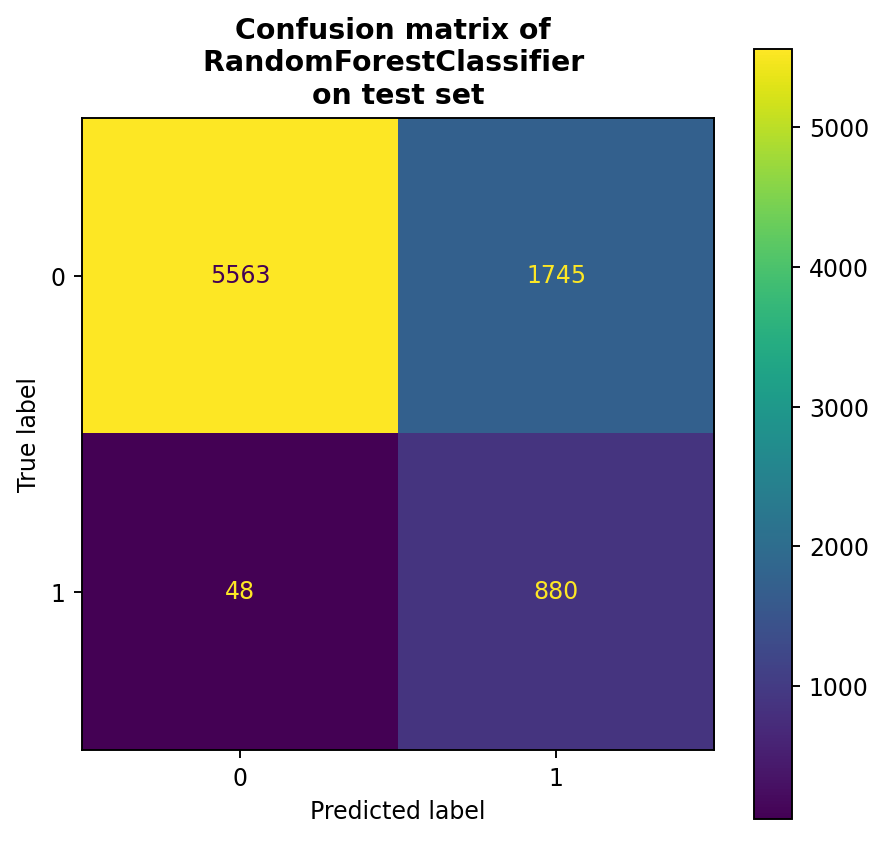

In [88]:
rf_confusion_matrix = confusion_matrix(y_test, rf_best_model.predict(X_test))
cfd = ConfusionMatrixDisplay(rf_confusion_matrix, display_labels=rf_best_model.classes_)
fig, ax = plt.subplots(figsize=(6,6), dpi=170)
cfd.plot(ax=ax)
ax.set_title(f'Confusion matrix of \n{rf_best_model.__class__.__name__} \non test set', weight='bold')
plt.savefig('conf_matx.png')

# Model interpretations

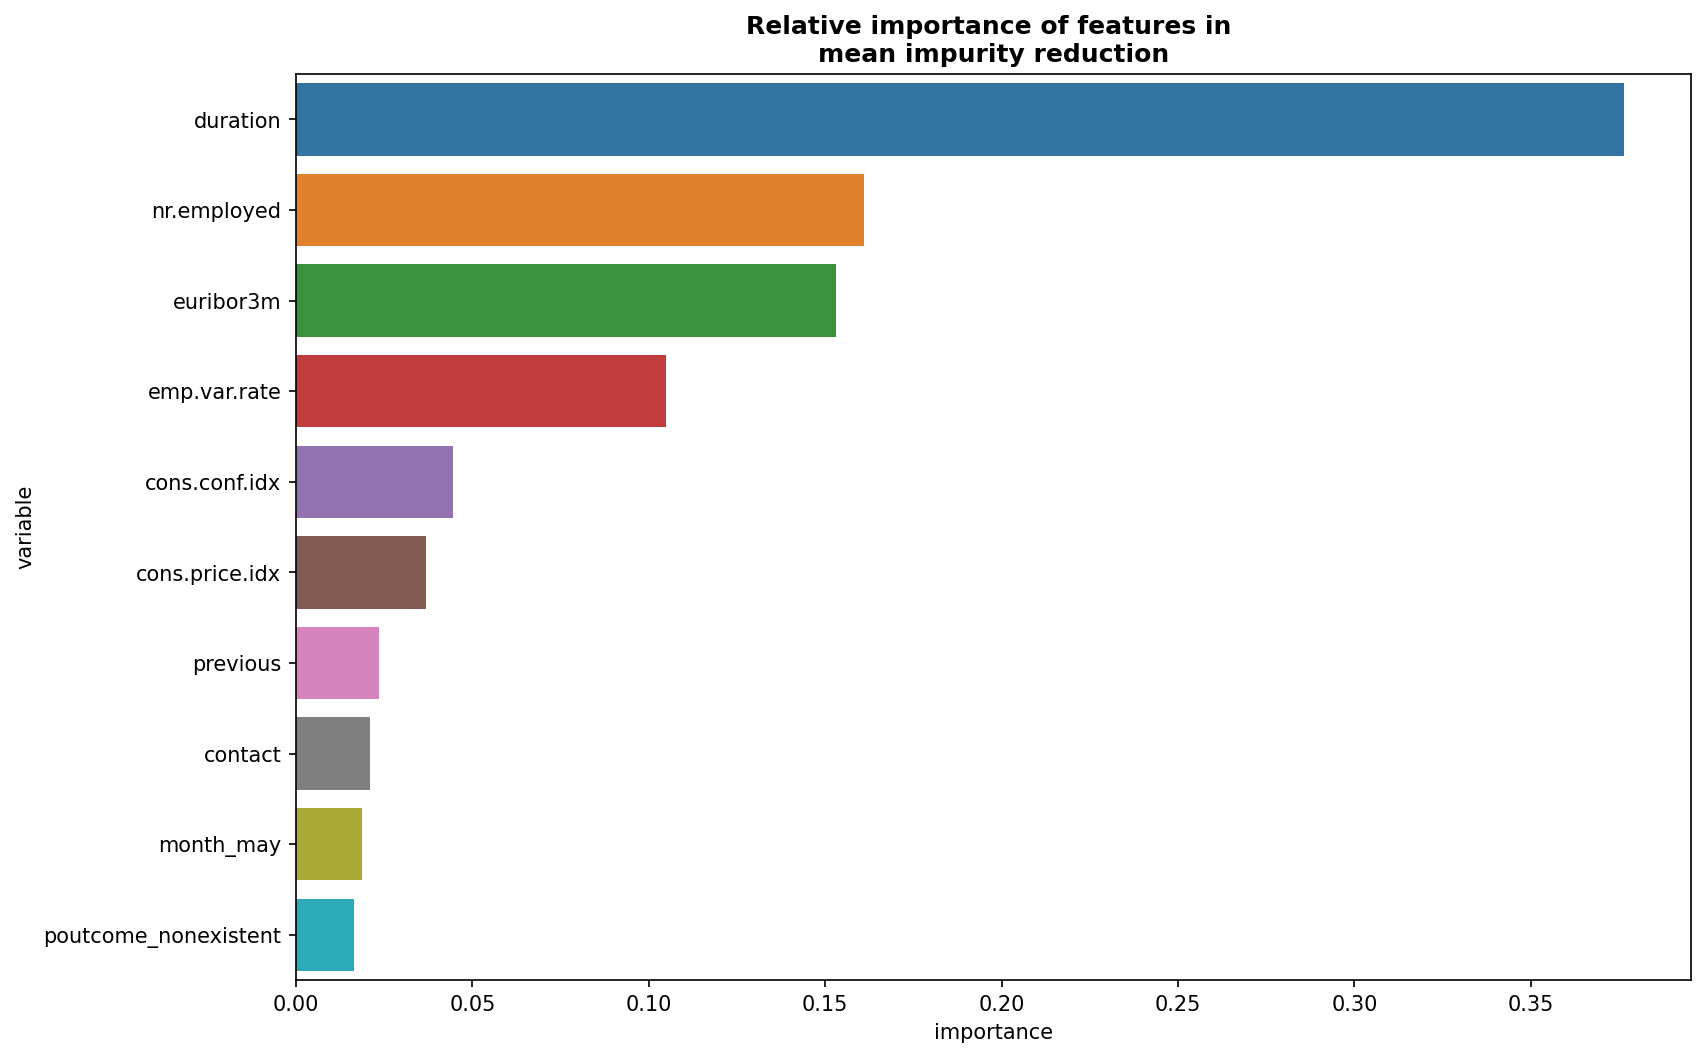

In [89]:
feat_names = rf_best_model.feature_names_in_
importances = rf_best_model.feature_importances_
imp_df = pd.DataFrame(
    {
        'variable': feat_names, 
        'importance': importances
    }
).sort_values(by='importance', ascending=False)

plt.figure(figsize=(12,8), dpi=150)
sns.barplot(
    data=imp_df.head(10),
    x='importance',
    y='variable'
)
plt.title(f'Relative importance of features in \nmean impurity reduction', weight='bold')
plt.savefig('feat_importance.png')

Although LR did not become the final model, its parametric interpretation is still of interest, because it's a fairly easy model to understand. Since this is a penalised coefficient model, the estimates will be strongly biased, and so will be their standard errors. Therefore p-values, which are computed from standard errors, will not be meaningful in its interpretation (Goeman et al., 2022, p.18). Therefore, we only interpret the coefficients at face value, and keep in mind that these coefficients move with the scaled quantities, rather than the quantities themselves.

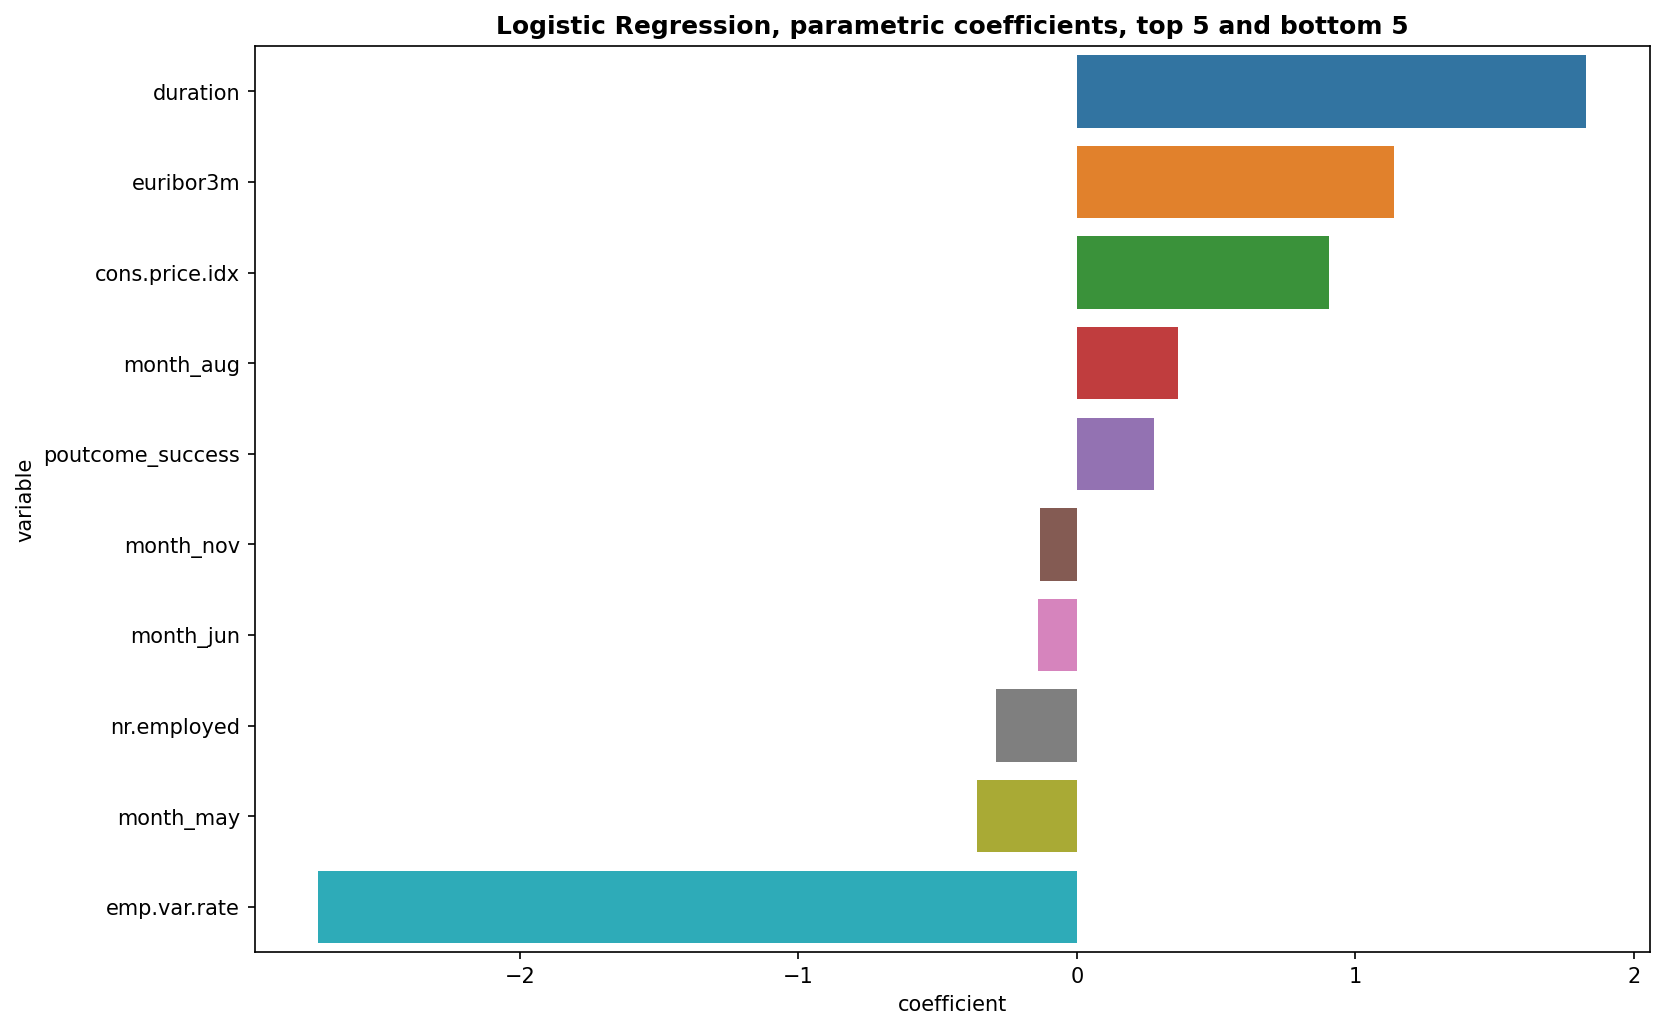

In [90]:
lr_coef = lr_best_model.coef_.flatten()
coef_df = pd.DataFrame(
    {
        'variable': feat_names,
        'coefficient': lr_coef        
    }
).sort_values(by='coefficient', ascending=False)

plt.figure(figsize=(12,8), dpi=150)
sns.barplot(
    data=pd.concat([coef_df.head(5), coef_df.tail(5)]),
    x='coefficient',
    y='variable'
)
plt.title(f'Logistic Regression, parametric coefficients, top 5 and bottom 5', weight='bold')
plt.savefig('LR_coef.png')

In [95]:
customer_info_cols = [
    'age',
    'job',
    'marital',
    'education',
    'default',
    'housing',
    'loan'
]

In [96]:
customer_info_data = data.loc[y_test.index][customer_info_cols]

In [97]:
y_test_pred = pd.Series(rf_best_model.predict(X_test), index=y_test.index, name='RF_prediction')

In [98]:
customer_info_data = pd.concat([customer_info_data, y_test_pred], axis=1)

In [99]:
customer_info_data.head()

age         job  marital            education  default  housing  loan  \
26381   40  management   single          high.school        0        1     0   
29051   44  management  married  professional.course        0        1     0   
31020   27  technician   single  professional.course        0        1     0   
38266   17     student   single  professional.course        0        0     1   
16219   27      admin.   single    university.degree        0        1     0   

       RF_prediction  
26381              1  
29051              1  
31020              0  
38266              1  
16219              0

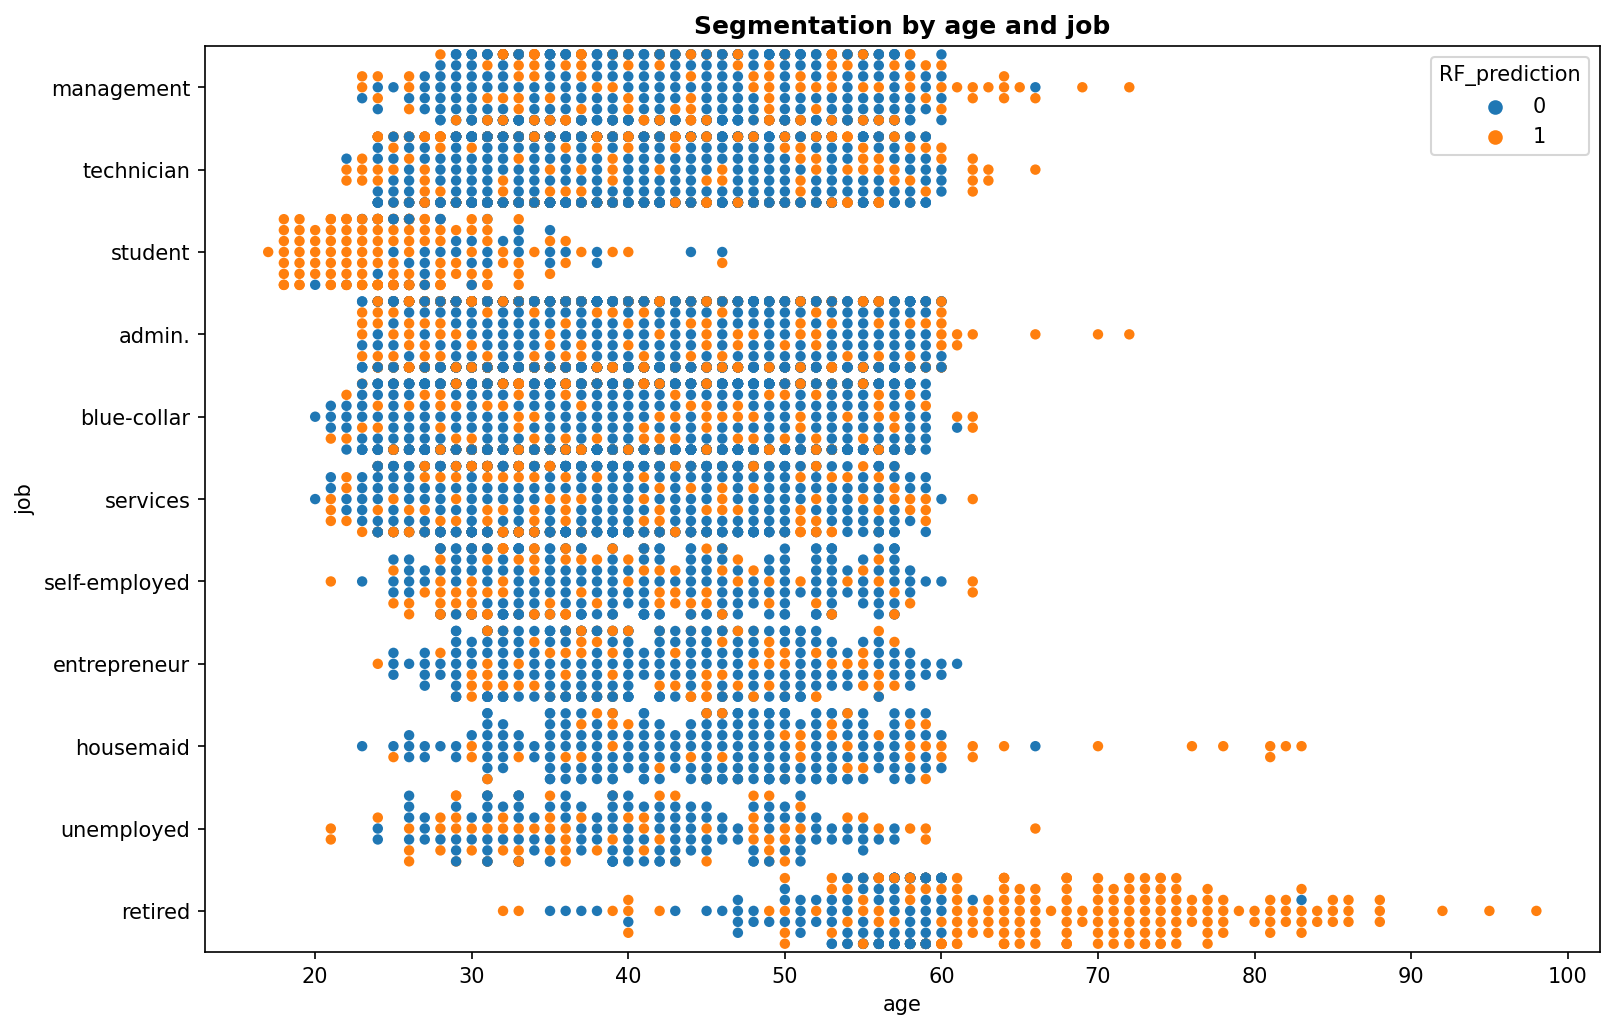

In [101]:
plt.figure(figsize=(12,8), dpi=150)
sns.swarmplot(
    data=customer_info_data,
    x='age',
    y='job',
    hue='RF_prediction'
)

plt.title('Segmentation by age and job', weight='bold')
plt.savefig('seg_age_job.png')
plt.show()

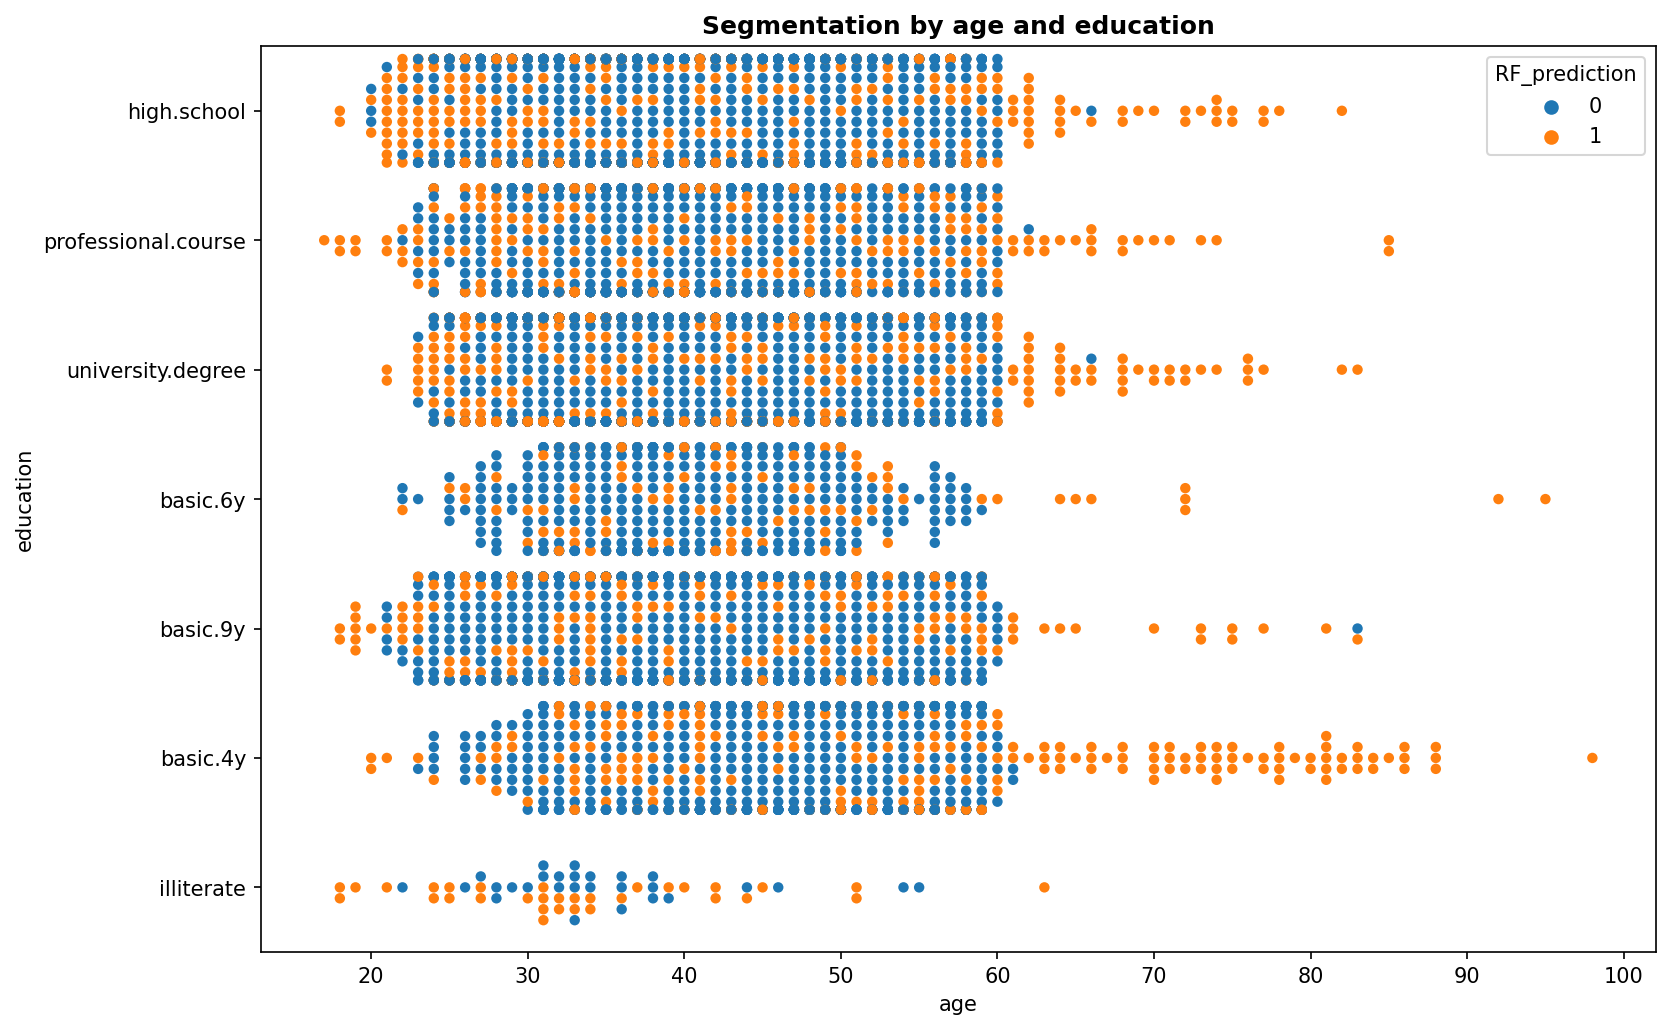

In [102]:
plt.figure(figsize=(12,8), dpi=150)
sns.swarmplot(
    data=customer_info_data,
    x='age',
    y='education',
    hue='RF_prediction'
)

plt.title('Segmentation by age and education', weight='bold')
plt.savefig('seg_age_edu.png')
plt.show()

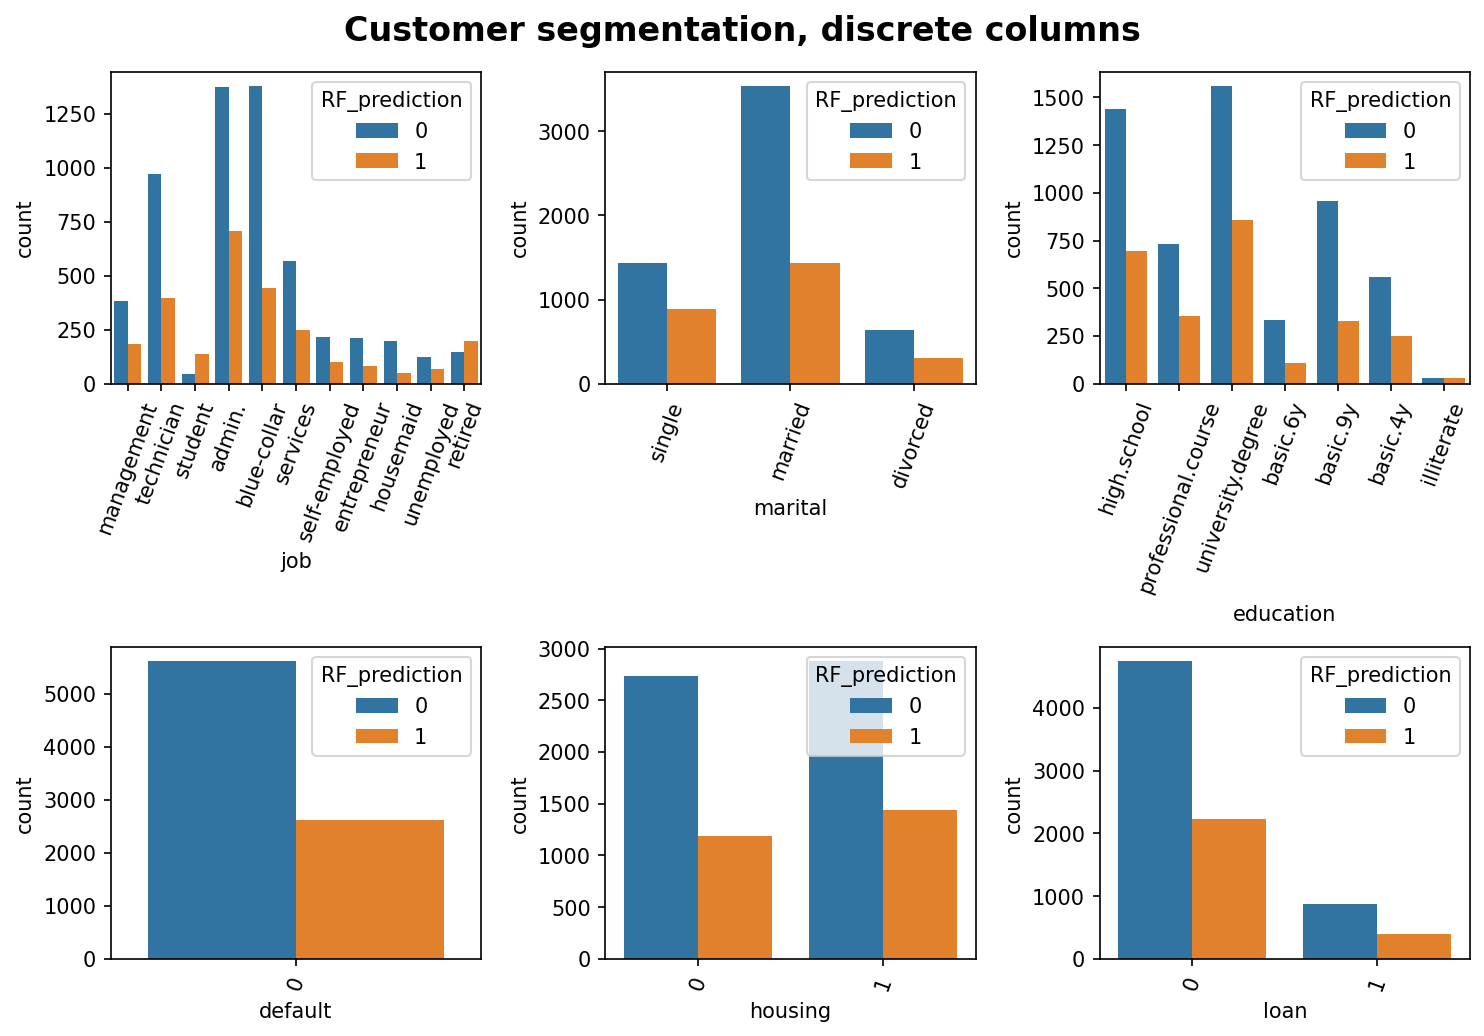

In [122]:
customer_info_cols_discrete = [
    'job',
    'marital',
    'education',
    'default',
    'housing',
    'loan'
]
nrow, ncol = 2, 3
fig, axes = plt.subplots(nrow, ncol, figsize=(10, 7), dpi=150)

for i in range(nrow * ncol):
    try:
        ax = plt.subplot(nrow, ncol, i+1)
        sns.countplot(data=customer_info_data, x=customer_info_cols_discrete[i], hue='RF_prediction', ax=ax)
        ax.tick_params(axis='x', labelrotation = 70)
    except IndexError:
        break
fig.suptitle('Customer segmentation, discrete columns', weight='bold', size=16)
plt.tight_layout()
plt.savefig('segmentation.png')
plt.show()

**REFERENCES**

Cadiz3. (2023, July). *Critical Information Summary: Cadiz3 Business SIP*. Retrieved November 3, 2023, from https://c.cadiz3.com.au/uploads/CIS_C3_Business_SIP_202307_eca18d3195.pdf

Goeman, J., Meijer, R., & Chaturvedi, N. (2022, April 23). *L1 and L2 Penalized Regression Models*. The Comprehensive R Archive Network. Retrieved November 3, 2023, from https://cran.r-project.org/web/packages/penalized/vignettes/penalized.pdf

*Linear models*. (2023). scikit-learn. Retrieved November 3, 2023, from https://scikit-learn.org/stable/modules/linear_model.html#id33

Optus. (2023). *nbn plans*. Retrieved November 3, 2023, from https://www.optus.com.au/broadband-nbn/home-broadband/plans/shop#optusmodem